In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
def get_led_positions(led_count, mpmt_locations):
    led_ring_radius = 24.
    led_positions = {}
    for k, v in mpmt_locations.items():
        for i in range(led_count):
            if abs(v[1]) > 100:
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count),0,np.cos(i*2*np.pi/led_count)])
            else:
                phi = np.arctan2(v[2], v[0])
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count)*np.sin(phi), np.cos(i*2*np.pi/led_count), -np.sin(i*2*np.pi/led_count)*np.cos(phi)])
    return led_positions

In [5]:
def get_image_feature_locations(feature_positions, camera_matrix, distortion, camera_rotations, camera_translations, image_size):
    image_feature_locations = {
        i : {list(feature_positions.keys())[f]:v for f, v in enumerate(cv2.projectPoints(np.array(list(feature_positions.values())), r, t, camera_matrix, distortion)[0].reshape((-1,2)))
             if v[0] > 0 and v[0] < image_size[0] and v[1] > 0 and v[1] < image_size[1]}
        for i, (r, t) in enumerate(zip(camera_rotations, camera_translations))}
    feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    return image_feature_locations

In [6]:
def get_smeared_feature_locations(image_feature_locations, pixel_error, image_size):
    smeared_feature_locations = {}
    for k, i in image_feature_locations.items():
        smeared_feature_locations[k] = {}
        for j, f in i.items():
            smeared = np.random.normal(f, pixel_error)
            if(smeared[0] > 0 and smeared[0] < image_size[0] and smeared[1] > 0 and smeared[1] < image_size[1]):
                smeared_feature_locations[k][j] = smeared
    smeared_feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Smeared feature in image counts:", Counter(smeared_feature_counts.values()))
    return smeared_feature_locations

In [7]:
def setup_led_simulation(feature_positions, image_feature_locations, focal_length, principle_point, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, radial_distortion)
    return fitter

In [8]:
def plot_images(image_feature_locations, image_size):
    for i in image_feature_locations.values():
        fig, ax = plt.subplots(figsize=(12,9))
        coords = np.rint(np.stack(list(i.values())))
        ax.scatter(coords[:,0], -coords[:,1], marker='s', s=0.2)
        ax.set_xlim((0, image_size[0]))
        ax.set_ylim((-image_size[1], 0))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.tight_layout()

In [9]:
def run_led_fit(fitter, led_positions):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_led_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_led_positions, position_errors

In [10]:
def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [11]:
def get_mpmt_centre_errors(reco_led_positions, mpmt_positions, led_count):
    reco_mpmt_positions = {k: np.mean([reco_led_positions[k + "-" + str(b)] for b in range(led_count)], axis=0)
                           for k in mpmt_positions.keys()}
    errors = np.array([linalg.norm(reco_mpmt_positions[k] - mpmt_positions[k]) for k in mpmt_positions.keys()])
    return errors

In [12]:
def get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_coun):
    reco_orientations = {}
    for k in mpmt_orientations.keys():
        c, n = geo.fit_plane(np.array([reco_led_positions[k + "-" + str(b)] for b in range(led_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        reco_orientations[k] = n
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], mpmt_orientations[k]))) for k in mpmt_orientations.keys()])
    return errors

In [13]:
def make_fig(title=None, xlabel=None, ylabel=None, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig, ax

In [14]:
def plot_geometry(led_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([l[0] for l in led_positions.values()], [l[2] for l in led_positions.values()], [l[1] for l in led_positions.values()], marker='*', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='o', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

In [15]:
def plot_reconstruction(reco_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,2], reco_positions[:,1], marker='*', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='o', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

In [16]:
pixel_errors = [1.0, 3.0, 5.0, 10.0]

In [17]:
pmt_locations = fit.read_3d_feature_locations("parameters/WCTE_16cShort_PMT_locations.txt", delimiter=" ")
#mpmt_locations = {k: v for k, v in pmt_locations.items() if int(k)%19==0}
mpmt_locations = fit.read_3d_feature_locations("parameters/WCTE_16cShort_centrePMT_locations.txt", delimiter=" ")
mpmt_orientations = {k: np.array((0,-1,0)) if v[1]>100
                     else np.array((0,1,0)) if v[1]<-100
                     else np.array((-v[0],0,-v[2]))/np.sqrt(v[0]**2+v[2]**2)
                     for k, v in mpmt_locations.items()}
led_count = 12
led_positions = get_led_positions(led_count, mpmt_locations)

In [18]:
mpmt_locations

{'19': array([160.01661746,  26.7375    ,  31.8292842 ]),
 '38': array([135.65553801,  26.7375    ,  90.64213261]),
 '57': array([ 90.64213261,  26.7375    , 135.65553801]),
 '76': array([ 31.8292842 ,  26.7375    , 160.01661746]),
 '95': array([-31.8292842 ,  26.7375    , 160.01661746]),
 '114': array([-90.64213261,  26.7375    , 135.65553801]),
 '133': array([-135.65553801,   26.7375    ,   90.64213261]),
 '152': array([-160.01661746,   26.7375    ,   31.8292842 ]),
 '171': array([-160.01661746,   26.7375    ,  -31.8292842 ]),
 '190': array([-135.65553801,   26.7375    ,  -90.64213261]),
 '209': array([ -90.64213261,   26.7375    , -135.65553801]),
 '228': array([ -31.8292842 ,   26.7375    , -160.01661746]),
 '247': array([  31.8292842 ,   26.7375    , -160.01661746]),
 '266': array([  90.64213261,   26.7375    , -135.65553801]),
 '285': array([135.65553801,  26.7375    , -90.64213261]),
 '304': array([160.01661746,  26.7375    , -31.8292842 ]),
 '323': array([160.01661746, -26.7375

In [19]:
mpmt_orientations

{'19': array([-0.98078528,  0.        , -0.19509032]),
 '38': array([-0.83146961,  0.        , -0.55557023]),
 '57': array([-0.55557023,  0.        , -0.83146961]),
 '76': array([-0.19509032,  0.        , -0.98078528]),
 '95': array([ 0.19509032,  0.        , -0.98078528]),
 '114': array([ 0.55557023,  0.        , -0.83146961]),
 '133': array([ 0.83146961,  0.        , -0.55557023]),
 '152': array([ 0.98078528,  0.        , -0.19509032]),
 '171': array([0.98078528, 0.        , 0.19509032]),
 '190': array([0.83146961, 0.        , 0.55557023]),
 '209': array([0.55557023, 0.        , 0.83146961]),
 '228': array([0.19509032, 0.        , 0.98078528]),
 '247': array([-0.19509032,  0.        ,  0.98078528]),
 '266': array([-0.55557023,  0.        ,  0.83146961]),
 '285': array([-0.83146961,  0.        ,  0.55557023]),
 '304': array([-0.98078528,  0.        ,  0.19509032]),
 '323': array([-0.98078528,  0.        , -0.19509032]),
 '342': array([-0.83146961,  0.        , -0.55557023]),
 '361': a

In [20]:
pixel_errors = [1.0, 3.0, 5.0, 10.0]

# Simulation with Sony A6000

In [21]:
focal_length = np.array([2925.84685880484, 2930.0351899542])
principle_point = np.array([3000, 2000])
radial_distortion = np.array([-0.251288719187471, 0.0622370807856553])#[-0.28009, 0.11246, -0.02736])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)
image_size = np.array([6000, 4000])
image_area = [[0,image_size[0]],[0,image_size[1]]]

## 8 camera corner configuration

In [22]:
all_cam_positions = np.array([[97.47275687, 14.93703117, 99.94996814],
                              [29.15674544, 141.7448364, 147.4176074],
                              [44.82084089, 266.7725, -44.9380583],
                              [29.29952975, 16.2275, -28.97664714],
                              [-97.47275687 , 14.93703117, -99.94996814],
                              [99.94996814, 272.2629688, -97.47275687],
                              [99.94996814, 14.93703117, -97.47275687],
                              [-99.94996814, 14.93703117, 97.47275687],
                              [-29.15674544, 141.7448364, -147.4176074],
                              [-147.4176074, 141.7448364, 29.15674544],
                              [-99.94996814, 272.2629688, 97.47275687],
                              [97.47275687, 272.2629688, 99.94996814],
                              [147.4176074, 141.7448364, -29.15674544],
                              [-97.47275687, 272.2629688, -99.94996814]])
corner_cam_positions = all_cam_positions[(0,4,5,6,7,10,11,13),:]
cam_offsets = np.mean(corner_cam_positions, axis=0)
all_cam_positions = all_cam_positions - cam_offsets
corner_cam_positions = corner_cam_positions - cam_offsets

In [23]:
corner_cam_directions = [[-1, +1.9, -1],
                         [+1, +1.9, +1],
                         [-1, -1.9, +1],
                         [-1, +1.9, +1],
                         [+1, +1.9, -1],
                         [+1, -1.9, -1],
                         [-1, -1.9, -1],
                         [+1, -1.9, +1]]

In [24]:
# camera_radial_position = 163.0
# camera_halfz_position = 168.0
# camera_positions = np.array([
#     [ camera_radial_position/np.sqrt(2),  camera_halfz_position,  camera_radial_position/np.sqrt(2)],
#     [ camera_radial_position/np.sqrt(2),  camera_halfz_position, -camera_radial_position/np.sqrt(2)],
#     [-camera_radial_position/np.sqrt(2),  camera_halfz_position,  camera_radial_position/np.sqrt(2)],
#     [-camera_radial_position/np.sqrt(2),  camera_halfz_position, -camera_radial_position/np.sqrt(2)],
#     [ camera_radial_position/np.sqrt(2), -camera_halfz_position,  camera_radial_position/np.sqrt(2)],
#     [ camera_radial_position/np.sqrt(2), -camera_halfz_position, -camera_radial_position/np.sqrt(2)],
#     [-camera_radial_position/np.sqrt(2), -camera_halfz_position,  camera_radial_position/np.sqrt(2)],
#     [-camera_radial_position/np.sqrt(2), -camera_halfz_position, -camera_radial_position/np.sqrt(2)]])
# camera_directions = [[-1, -1.9, -1],
#                      [-1, -1.9,  1],
#                      [ 1, -1.9, -1],
#                      [ 1, -1.9,  1],
#                      [-1,  1.9, -1],
#                      [-1,  1.9,  1],
#                      [ 1,  1.9, -1],
#                      [ 1,  1.9,  1]]
camera_positions = corner_cam_positions
camera_directions = corner_cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({4: 664, 6: 224, 5: 144, 8: 136, 3: 80, 7: 24})


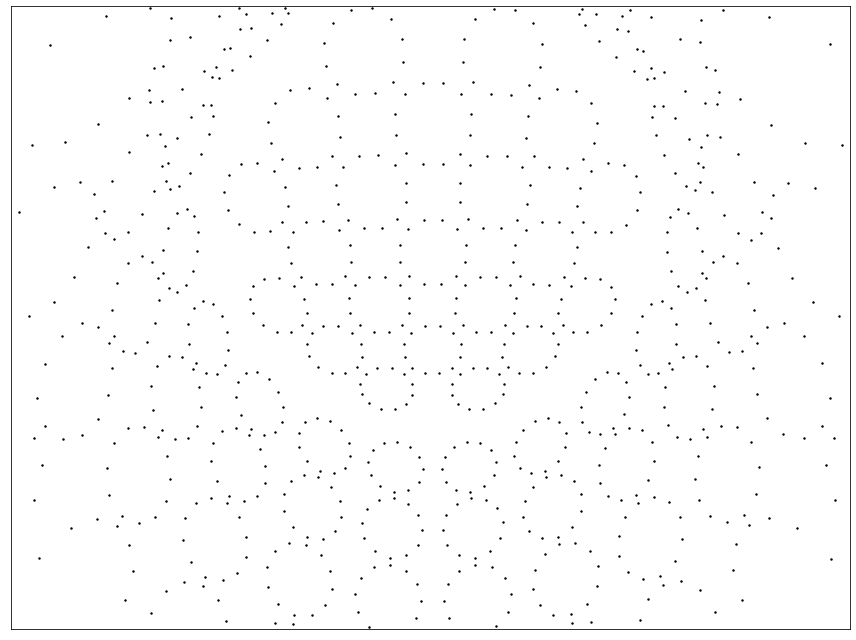

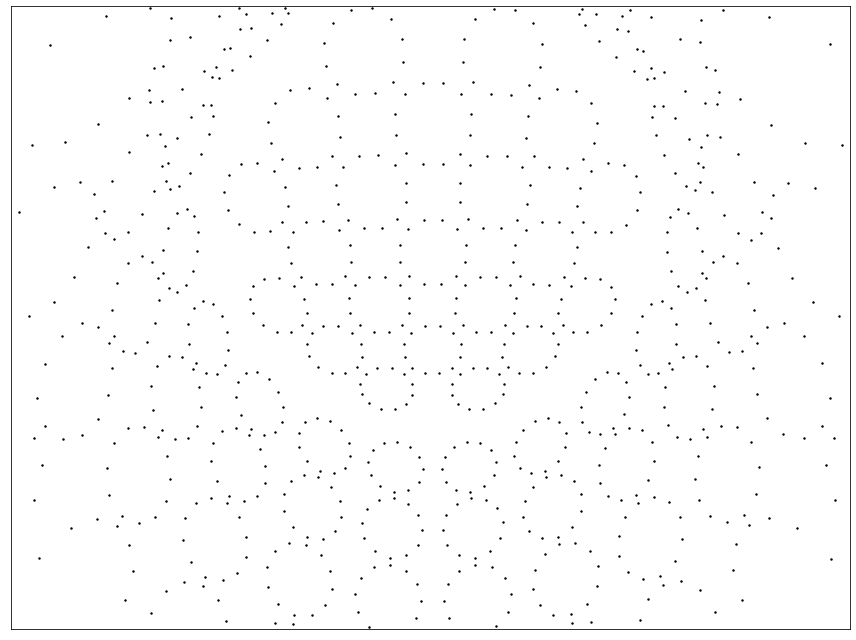

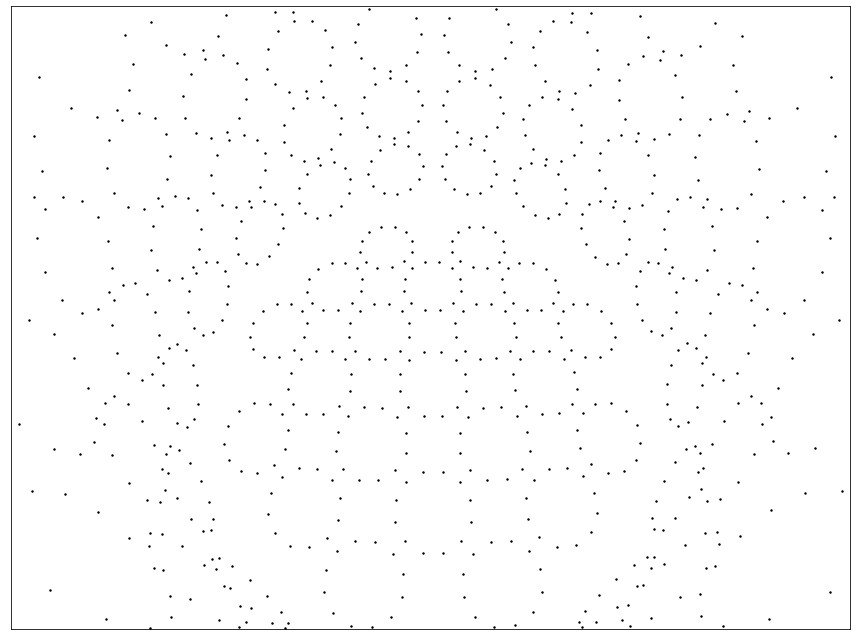

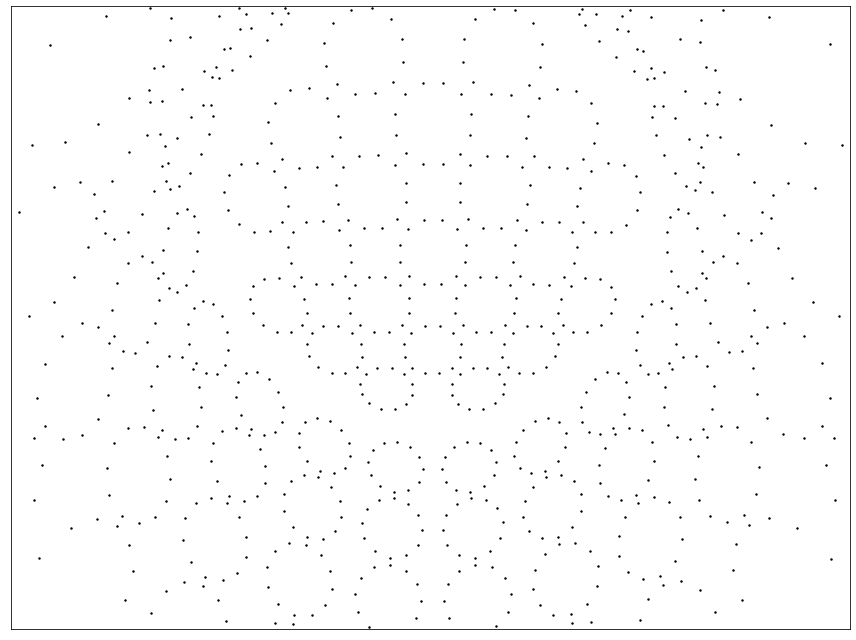

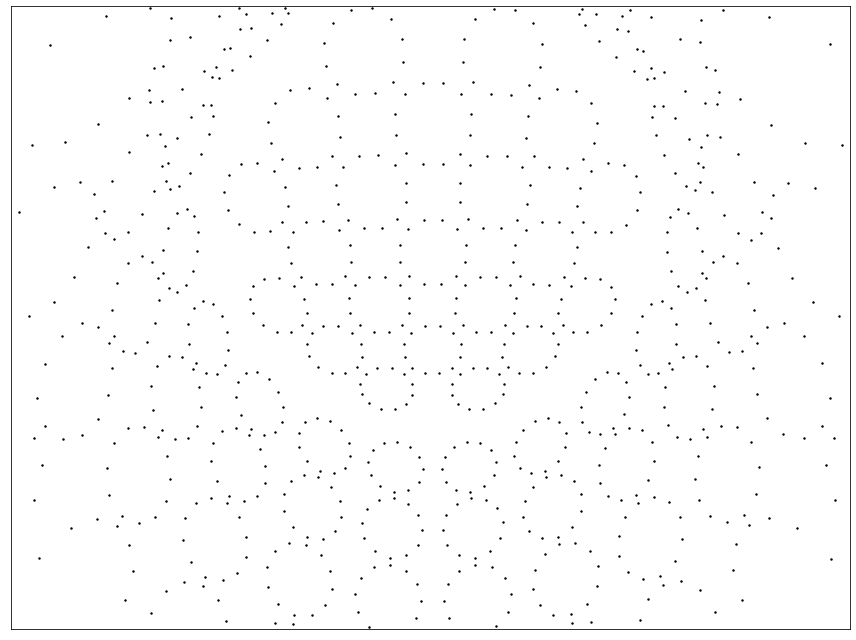

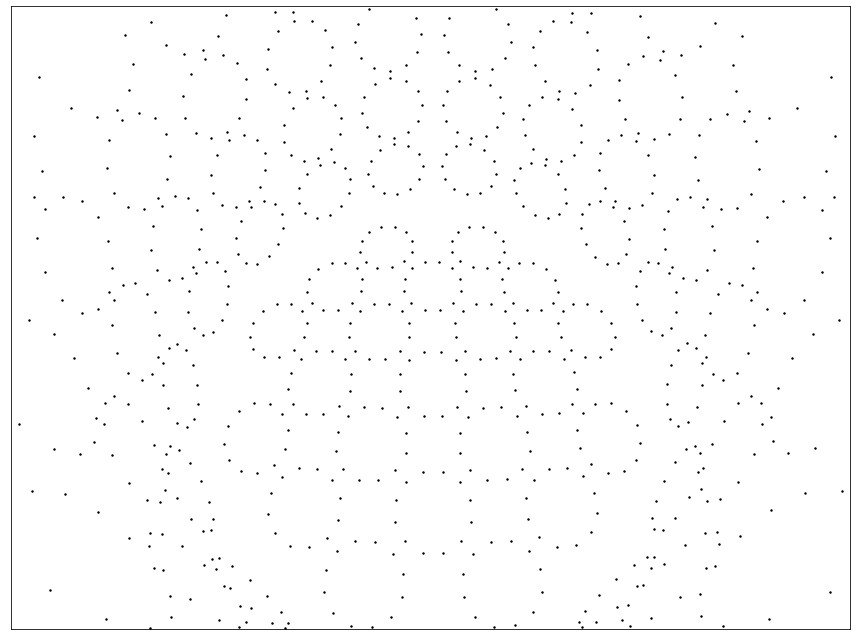

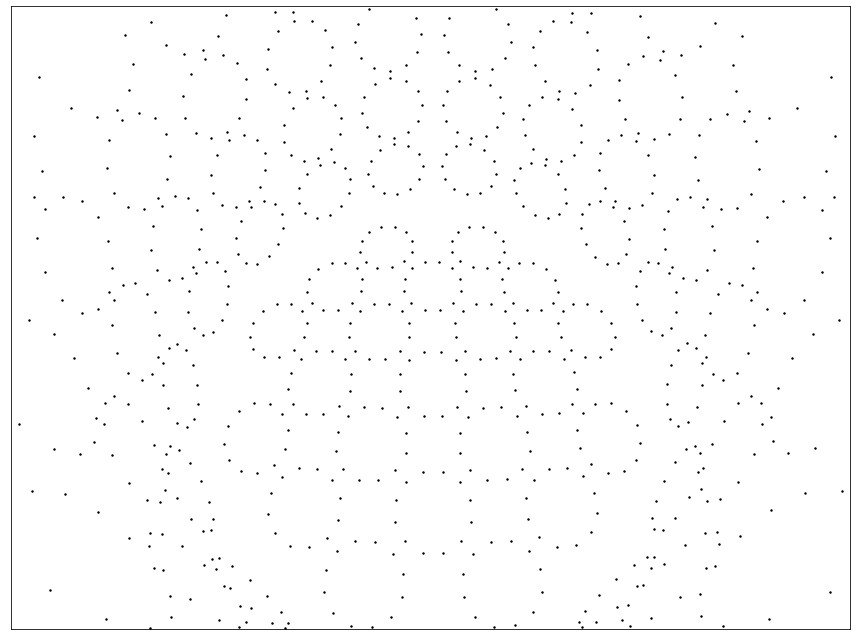

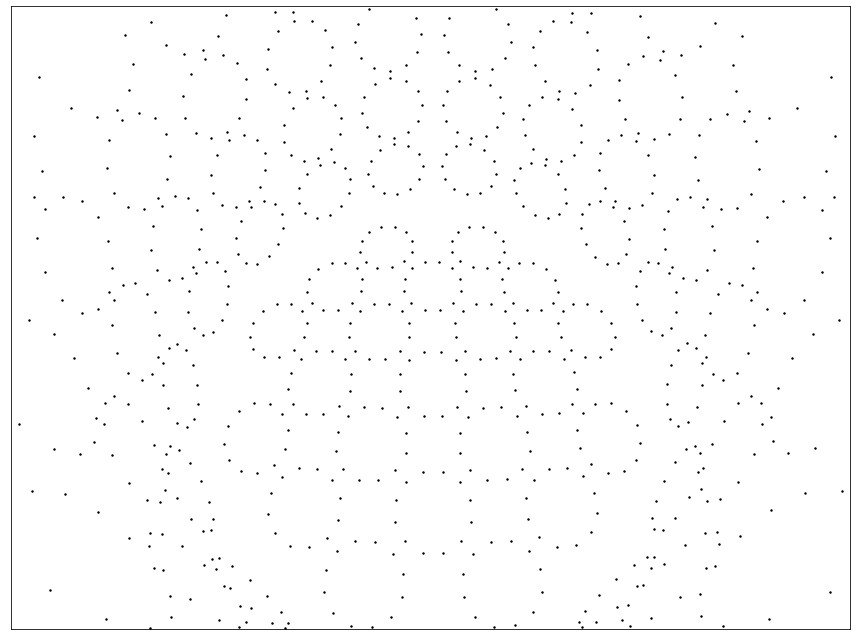

In [25]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

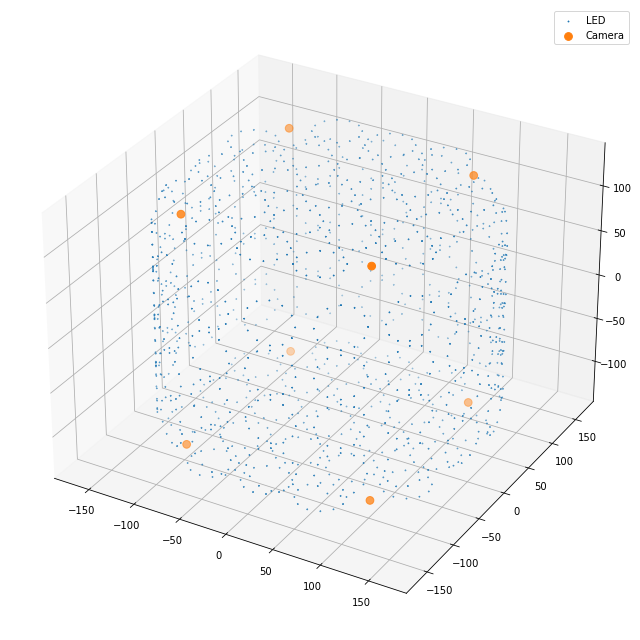

In [26]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:15.376666300026493   max: 109.64050368612064
image 1 reprojection errors:    average:15.202131478994277   max: 69.51272526709528
image 2 reprojection errors:    average:15.716292780251871   max: 181.94042863230572
image 3 reprojection errors:    average:14.98964337813133   max: 100.1618742507683
image 4 reprojection errors:    average:15.239792261548397   max: 145.3848426099025
image 5 reprojection errors:    average:15.263250576431226   max: 110.38157697544744
image 6 reprojection errors:    average:15.556337866603752   max: 122.50578466507639
image 7 reprojection errors:    average:15.43842026045658   max: 138.9462934612739
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1215e+06                                    1.51e+06    
       1              2         3.3796e+03      1.

      16             17         2.7529e+05      1.15e+00       1.72e-02       1.53e+02    
      17             18         2.7528e+05      1.11e+00       8.15e-03       7.72e+01    
      18             19         2.7528e+05      1.35e+00       2.08e-02       1.85e+02    
      19             20         2.7528e+05      1.31e+00       8.68e-03       8.04e+01    
      20             21         2.7528e+05      1.38e+00       2.19e-02       1.90e+02    
      21             22         2.7528e+05      1.34e+00       8.67e-03       8.35e+01    
      22             23         2.7528e+05      1.42e+00       2.30e-02       1.95e+02    
      23             24         2.7528e+05      1.38e+00       8.68e-03       8.62e+01    
      24             25         2.7527e+05      1.46e+00       2.42e-02       1.99e+02    
      25             26         2.7527e+05      1.41e+00       8.70e-03       8.87e+01    
      26             27         2.7527e+05      1.50e+00       2.56e-02       2.04e+02    

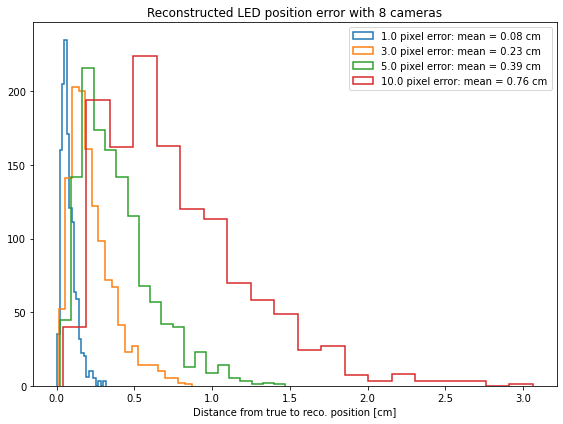

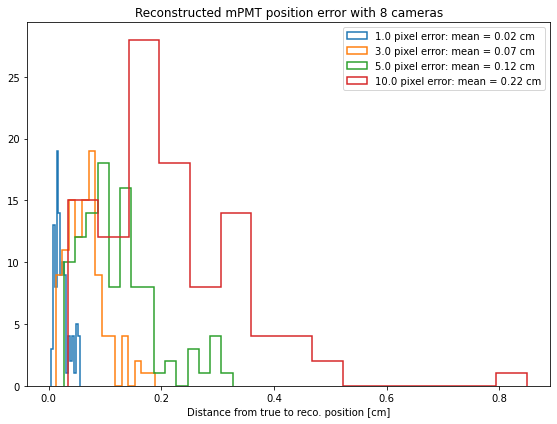

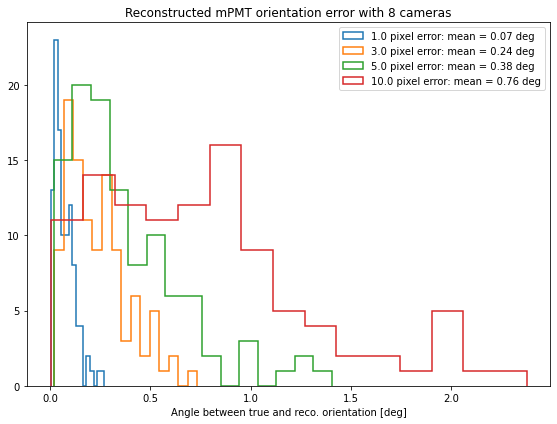

In [27]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

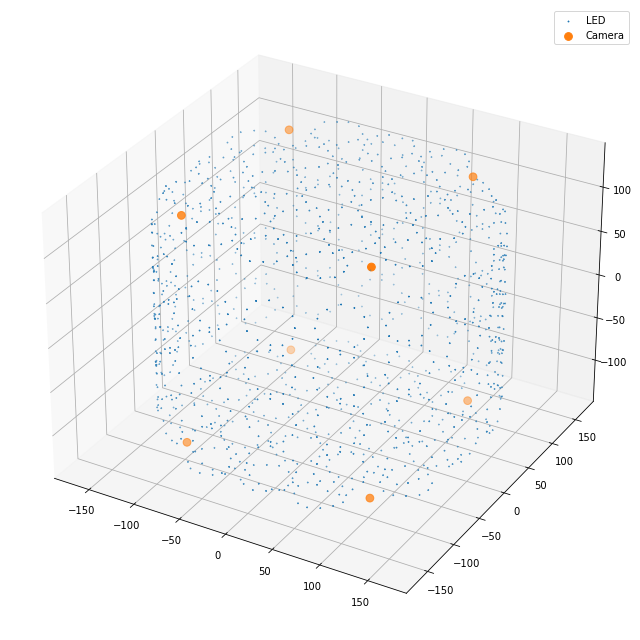

In [28]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 4 camera corner configuration

In [29]:
corner_4cam_positions = all_cam_positions[(0,4,5,10),:]

In [30]:
corner_4cam_directions = [[-1, +1.9, -1],
                         [+1, +1.9, +1],
                         [-1, -1.9, +1],
                         [+1, -1.9, -1],
                         ]

In [32]:
camera_positions = corner_4cam_positions
camera_directions = corner_4cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0])#, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1232
Feature in image counts: Counter({2: 776, 3: 308, 4: 148})


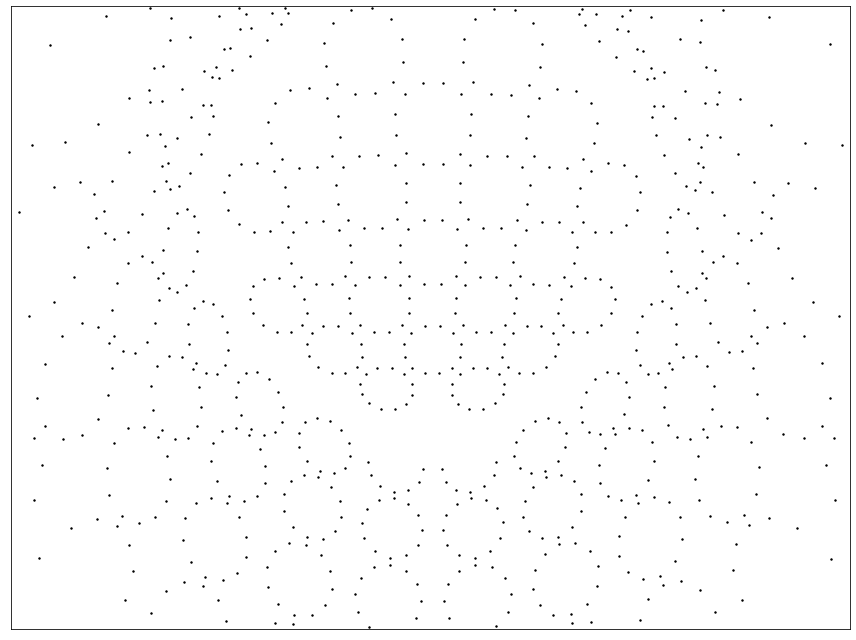

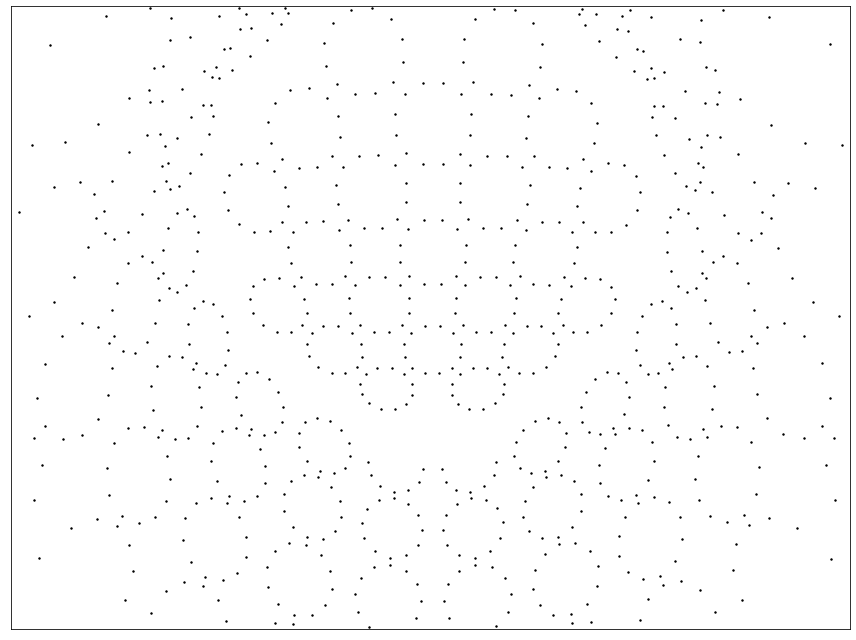

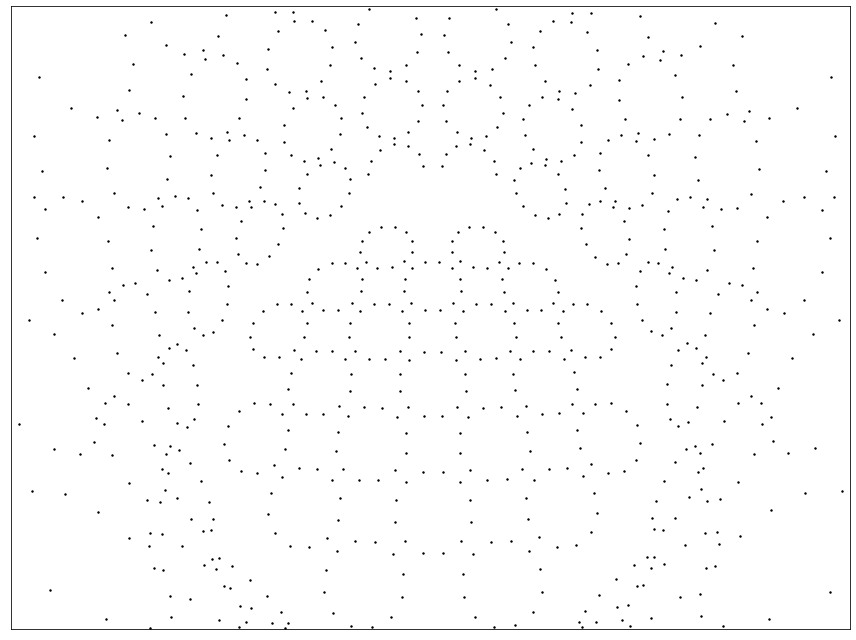

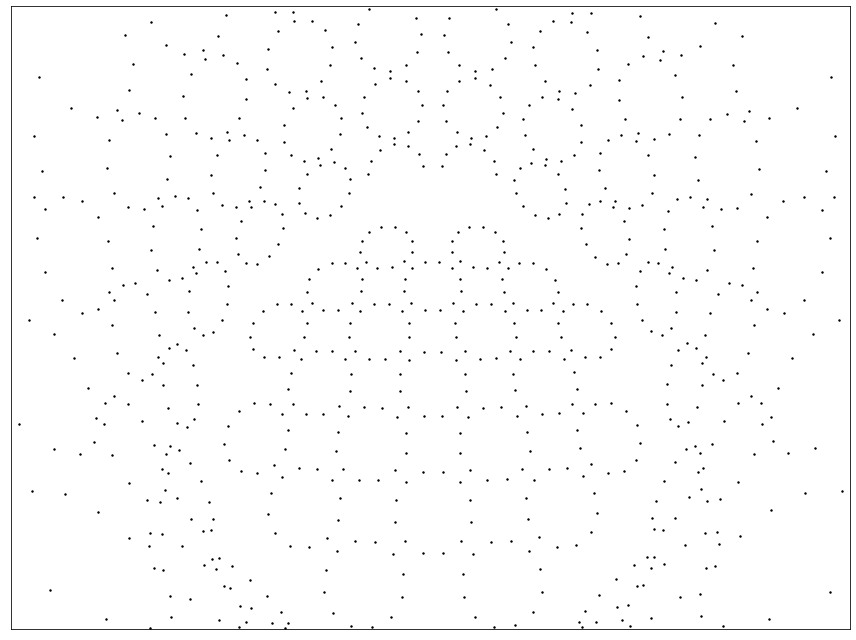

In [33]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

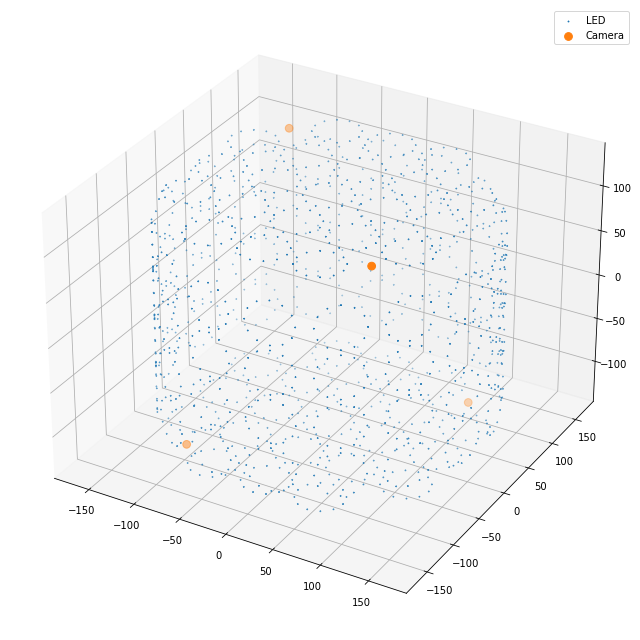

In [34]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
4 images with total of  1232 features
image 0 reprojection errors:    average:15.484589788583829   max: 80.78509801983431
image 1 reprojection errors:    average:15.722812572576329   max: 121.31577374715337
image 2 reprojection errors:    average:15.489355196558432   max: 135.22456030605278
image 3 reprojection errors:    average:14.998362169162379   max: 88.51649209633774
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4089e+05                                    9.35e+05    
       1              2         9.7842e+02      5.40e+05       6.12e+01       3.66e+04    
       2              3         7.7984e+02      1.99e+02       5.03e-01       2.17e+02    
       3              4         7.7811e+02      1.73e+00       2.99e-01       7.92e+01    
       4              5         7.7788e+02      2.30e-01       3.43e-02       3.91e+01    
       5              

KeyError: '722-4'

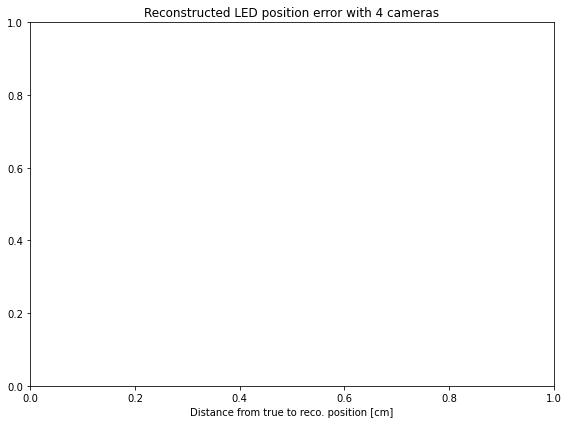

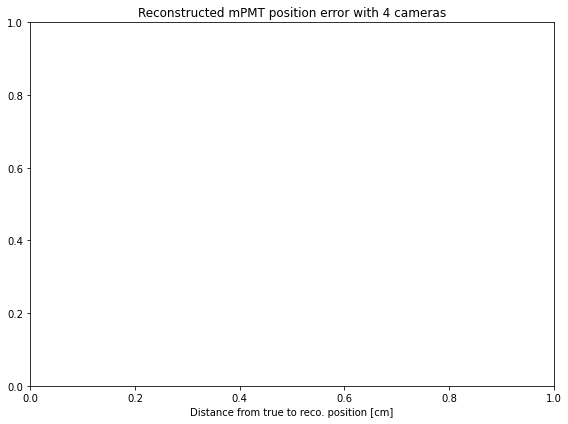

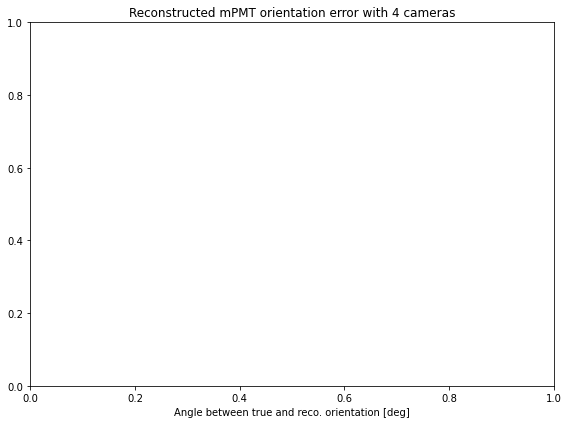

In [35]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

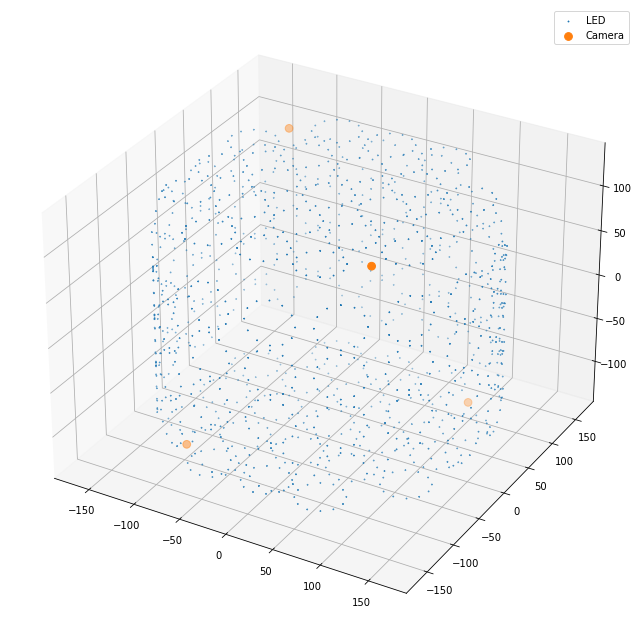

In [36]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 6 camera corner configuration

In [37]:
corner6_cam_positions = all_cam_positions[(4,5,6,7,10,11),:]

In [38]:
corner6_cam_directions = [[+1, +1.9, +1],
                          [-1, -1.9, +1],
                          [-1, +1.9, +1],
                          [+1, +1.9, -1],
                          [+1, -1.9, -1],
                          [-1, -1.9, -1]]

In [39]:
camera_positions = corner6_cam_positions
camera_directions = corner6_cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({3: 708, 4: 196, 5: 150, 6: 142, 2: 76})


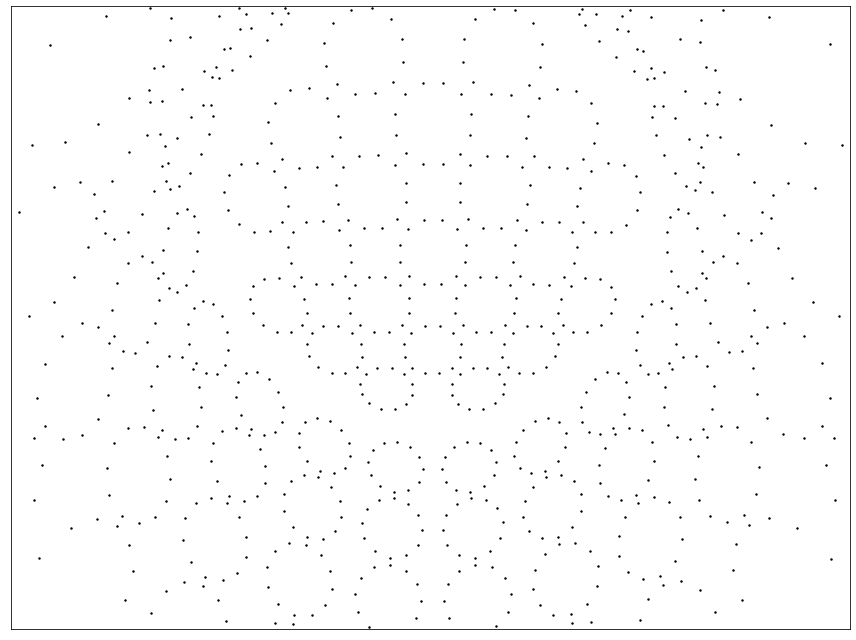

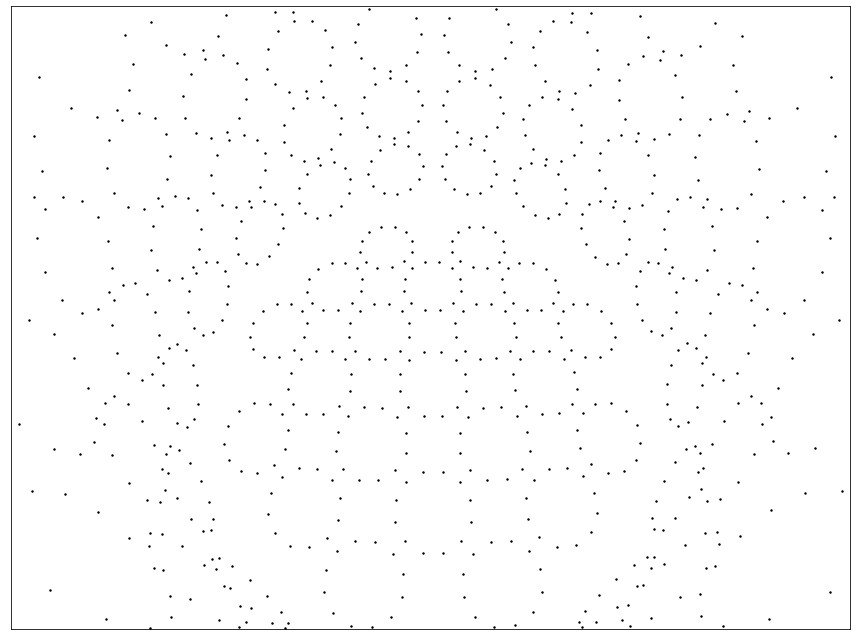

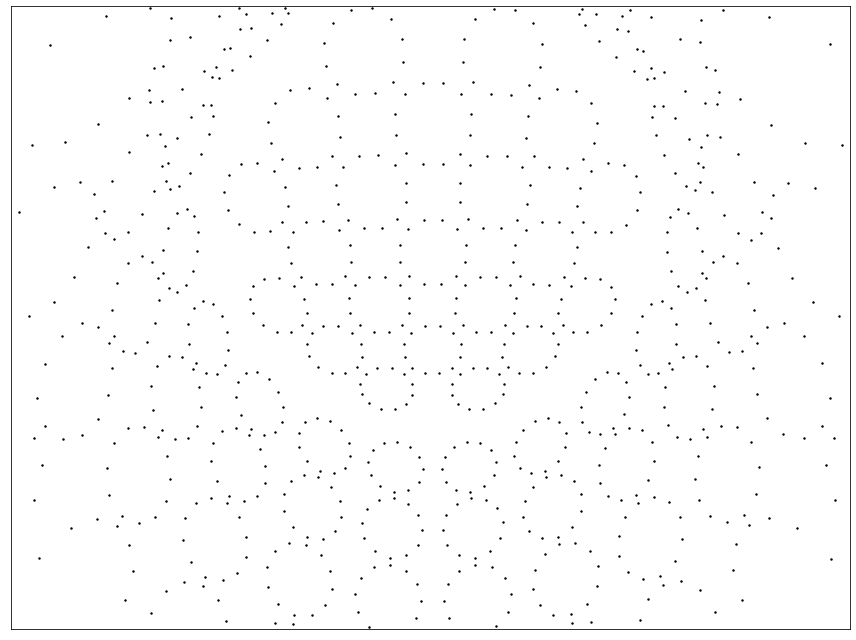

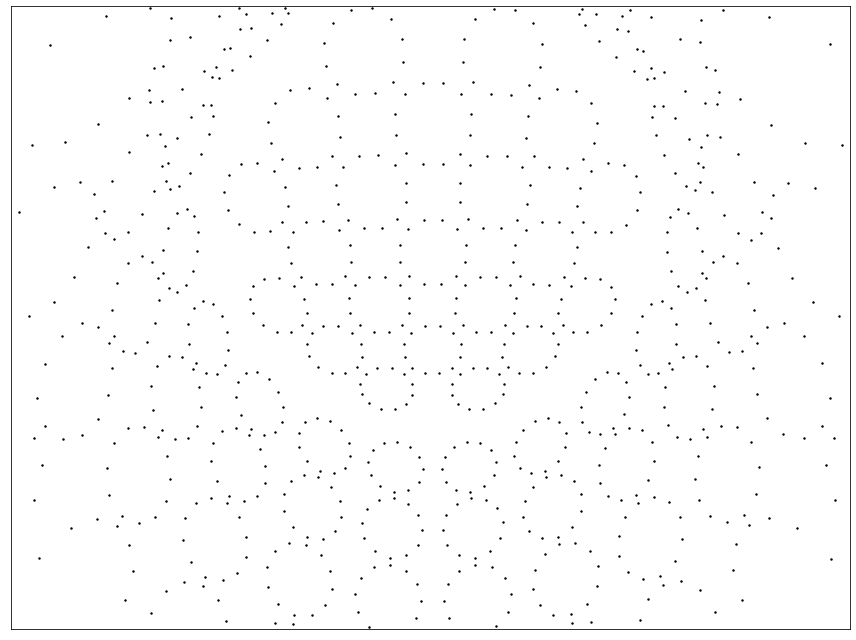

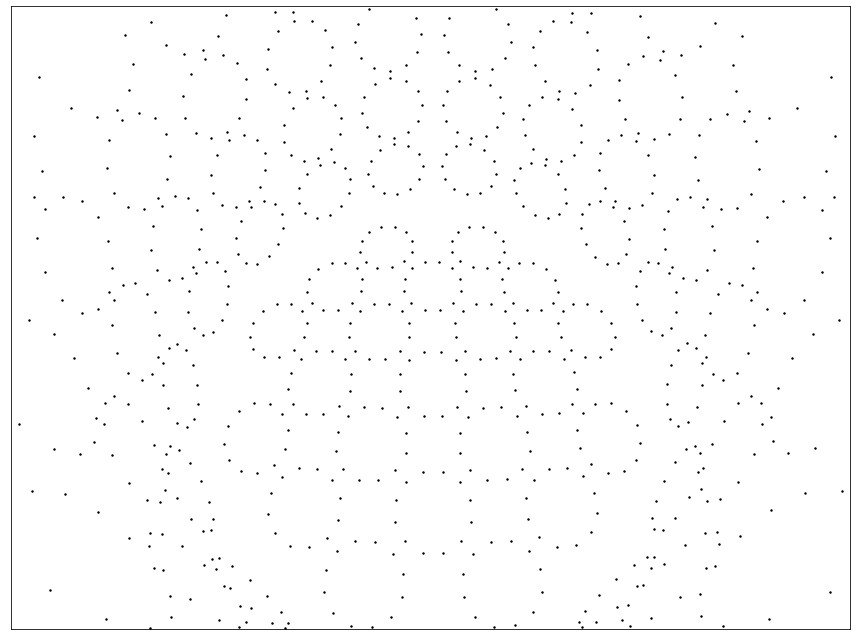

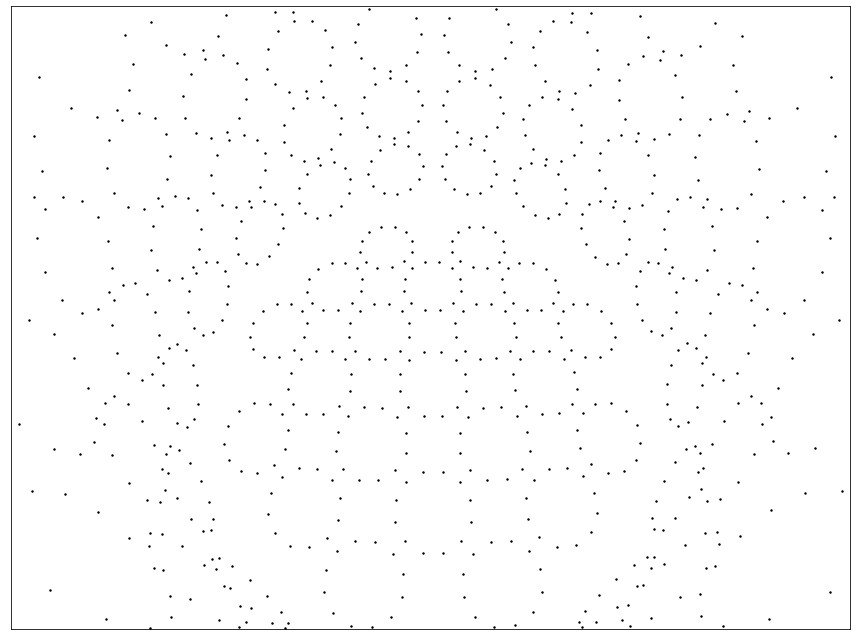

In [40]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

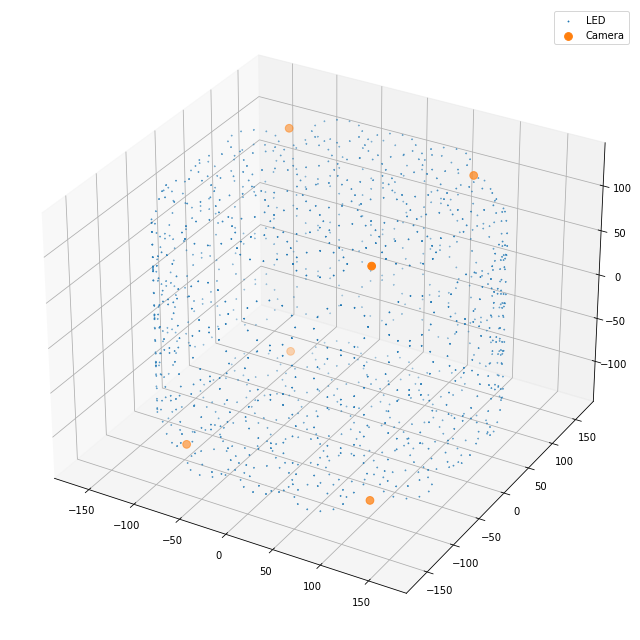

In [41]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
6 images with total of  1272 features
image 0 reprojection errors:    average:15.228950797424705   max: 96.56510070201077
image 1 reprojection errors:    average:15.161782116486421   max: 110.07189736159573
image 2 reprojection errors:    average:15.351520057105907   max: 75.38681862942737
image 3 reprojection errors:    average:15.119166183329087   max: 88.01161094537923
image 4 reprojection errors:    average:15.16365420925013   max: 108.25721626785058
image 5 reprojection errors:    average:15.952563038260042   max: 132.3325093063735
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.1236e+05                                    1.67e+06    
       1              2         1.9521e+03      8.10e+05       6.15e+01       3.19e+04    
       2              3         1.7700e+03      1.82e+02       1.08e+00       1.47e+03    
       3              4         1.760

      44             45         1.6010e+04      3.75e-01       2.36e-02       1.06e+02    
      45             46         1.6010e+04      3.69e-01       1.21e-02       2.11e+01    
      46             47         1.6010e+04      3.63e-01       2.32e-02       9.98e+01    
      47             48         1.6009e+04      3.58e-01       1.20e-02       2.05e+01    
      48             49         1.6009e+04      2.20e-01       1.34e-02       8.28e+01    
      49             50         1.6009e+04      2.57e-01       9.48e-03       3.50e+01    
      50             51         1.6009e+04      7.86e-02       2.90e-03       2.75e+01    
`xtol` termination condition is satisfied.
Function evaluations 51, initial cost 8.1092e+05, final cost 1.6009e+04, first-order optimality 2.75e+01.
mean reprojection error: 2.276982408561192
max reprojection error: 8.649836025999104
mean reconstruction error: 0.2770247716168649
max reconstruction error: 1.386933879465432
=== Gaussian errors on feature image lo

      12             13         1.7823e+05      1.37e+01       1.51e-01       2.56e+02    
      13             14         1.7822e+05      1.30e+01       1.31e-01       1.31e+02    
      14             15         1.7820e+05      1.27e+01       1.44e-01       2.26e+02    
      15             16         1.7819e+05      1.22e+01       1.27e-01       1.34e+02    
      16             17         1.7818e+05      1.20e+01       1.39e-01       2.03e+02    
      17             18         1.7817e+05      9.53e+00       9.75e-02       1.21e+02    
      18             19         1.7816e+05      9.08e+00       1.18e-01       1.87e+02    
      19             20         1.7815e+05      8.57e+00       8.87e-02       1.14e+02    
      20             21         1.7814e+05      7.90e+00       1.03e-01       1.91e+02    
      21             22         1.7814e+05      7.21e+00       7.51e-02       1.31e+02    
      22             23         1.7813e+05      6.28e+00       8.26e-02       2.00e+02    

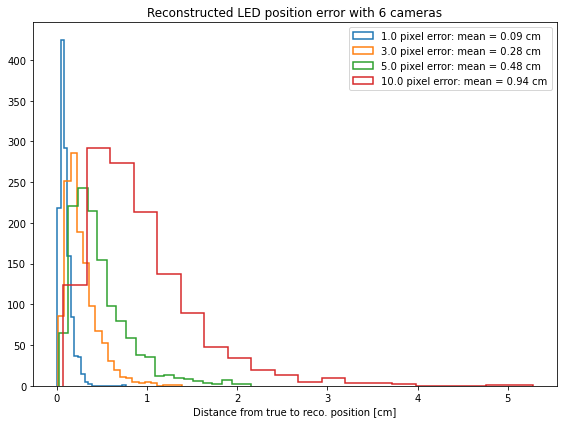

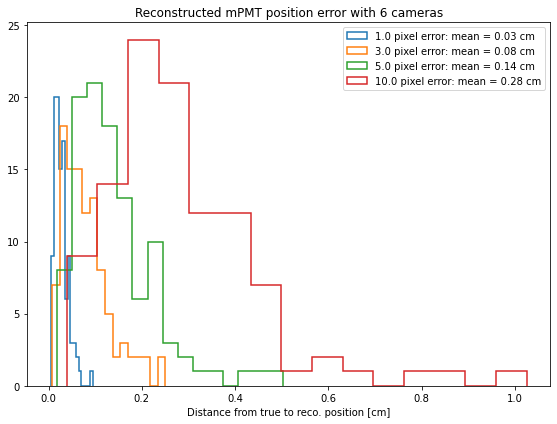

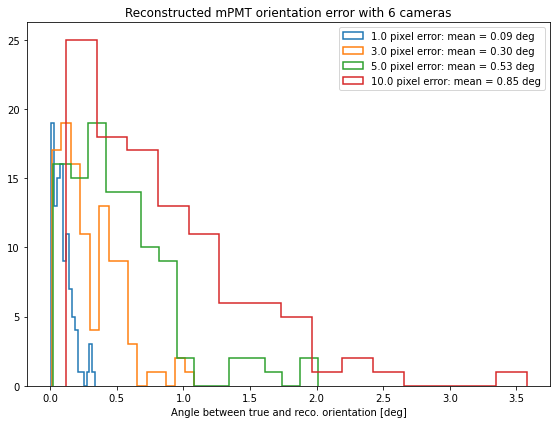

In [42]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

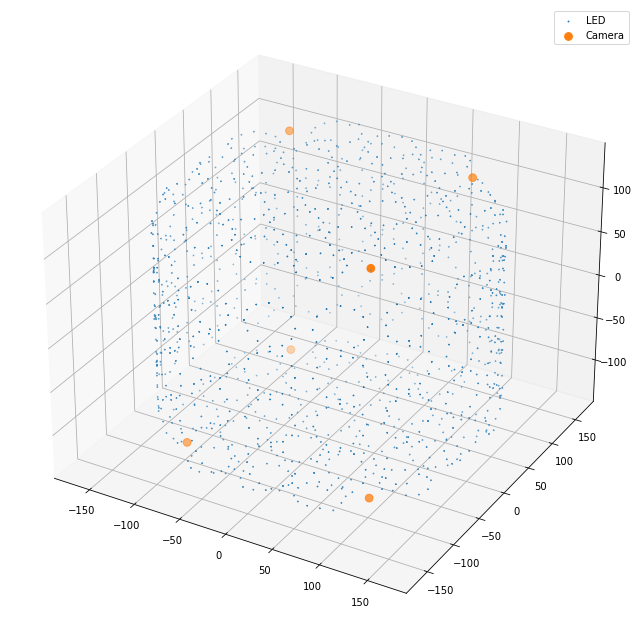

In [43]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 6 camera configuration A

In [44]:
wall_cam_positions = all_cam_positions[(1,2,3,8,9,12),:]

In [45]:
wall_cam_positions

array([[  29.15674544,   -1.85516359,  147.4176074 ],
       [  44.82084089,  123.17250001,  -44.9380583 ],
       [  29.29952975, -127.37249999,  -28.97664714],
       [ -29.15674544,   -1.85516359, -147.4176074 ],
       [-147.4176074 ,   -1.85516359,   29.15674544],
       [ 147.4176074 ,   -1.85516359,  -29.15674544]])

In [46]:
wall_cam_direcions = [[ 0,  0, -1],
                      [ 0, -1,  0],
                      [ 0, +1,  0],
                      [ 0,  0, +1],
                      [+1,  0,  0],
                      [-1,  0,  0]]

In [47]:
# camera_radial_position = 163.0
# camera_halfz_position = 168.0
# camera_positions = np.array([
#     [0, -camera_halfz_position, 0],
#     [0, camera_halfz_position, 0],
#     [camera_radial_position, 0, 0],
#     [-camera_radial_position, 0, 0],
#     [0, 0, camera_radial_position],
#     [0, 0, -camera_radial_position]])
# camera_directions = [[0, 1, 0],
#                      [0, -1, 0],
#                      [-1, 0, 0],
#                      [1, 0, 0],
#                      [0, 0, -1],
#                      [0, 0, 1]]
camera_positions = wall_cam_positions
camera_directions = wall_cam_direcions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([np.pi/2, 0, np.pi/2, 0, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1223
Feature in image counts: Counter({3: 715, 2: 273, 4: 204, 5: 31})


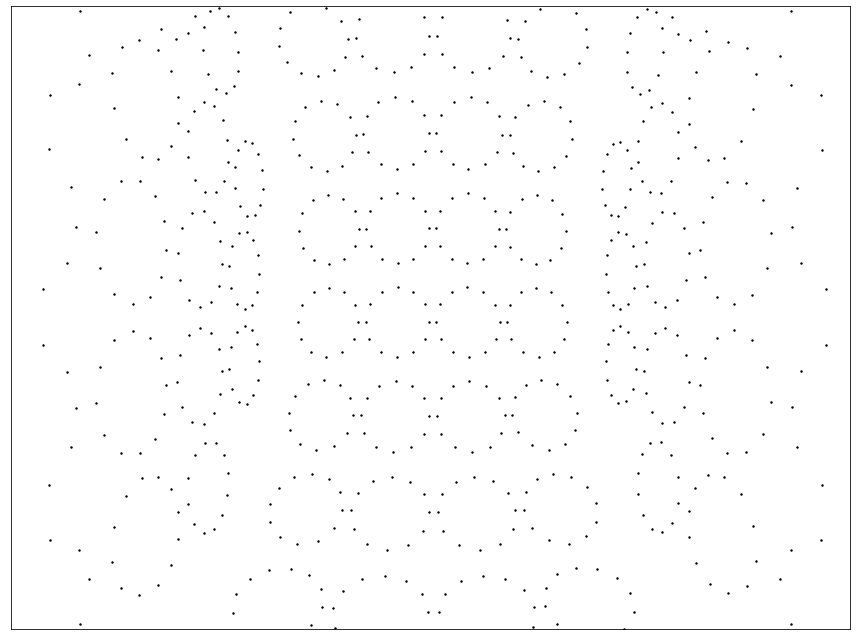

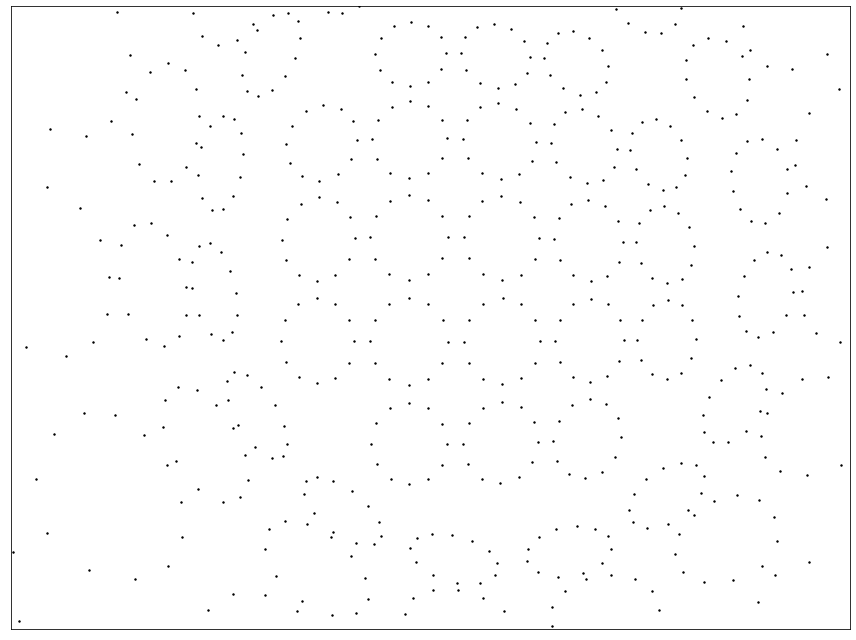

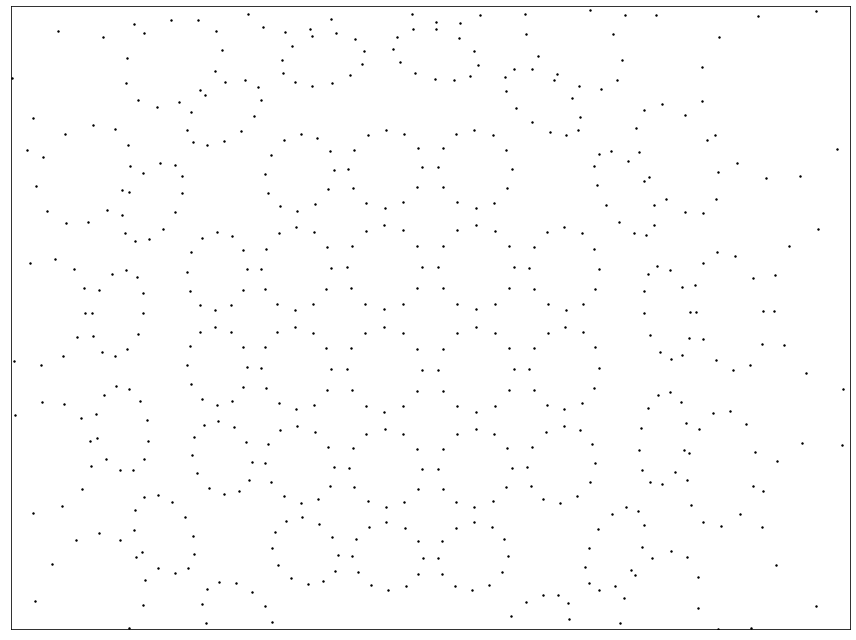

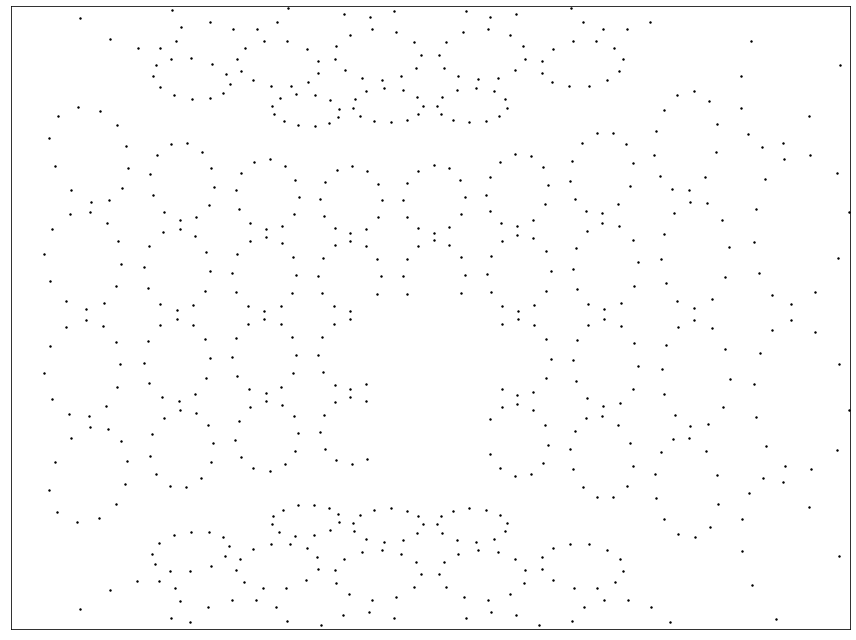

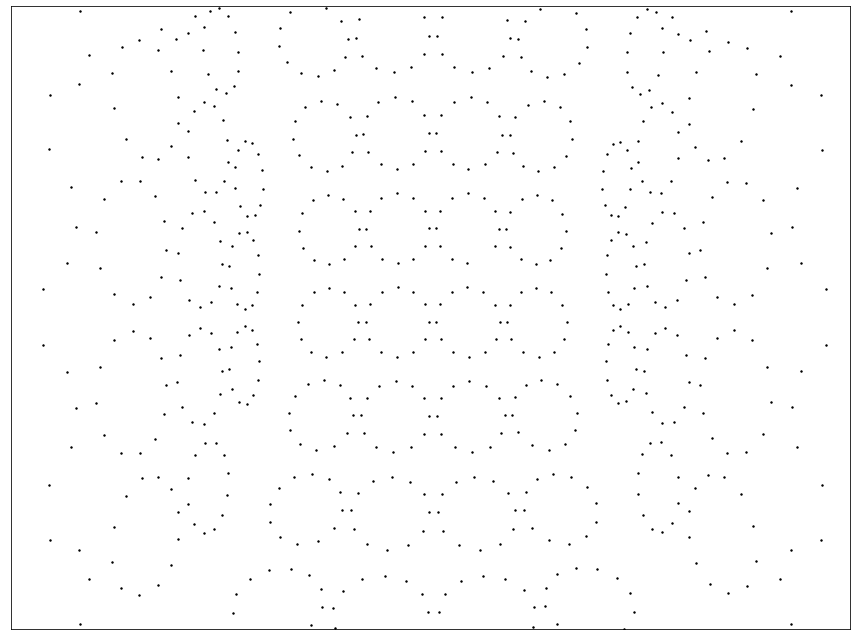

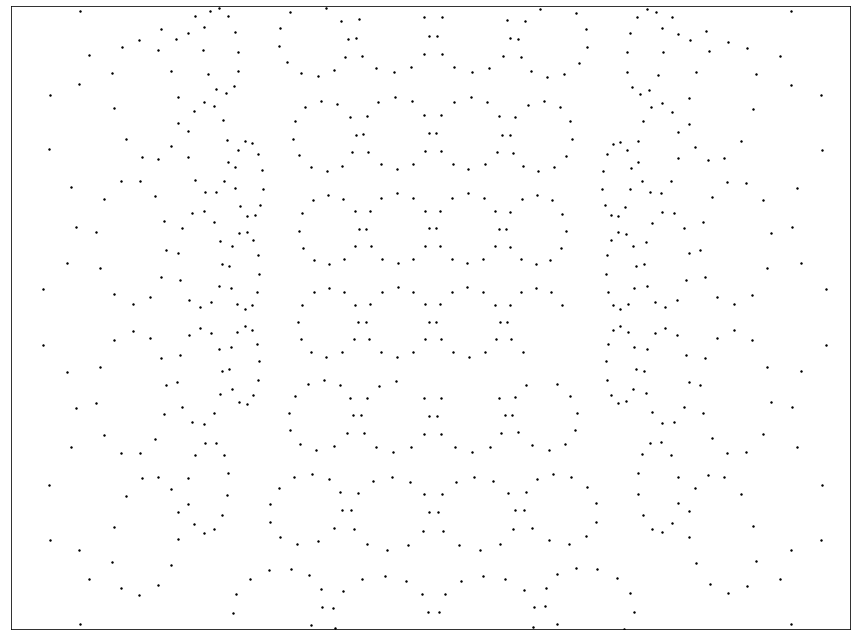

In [48]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

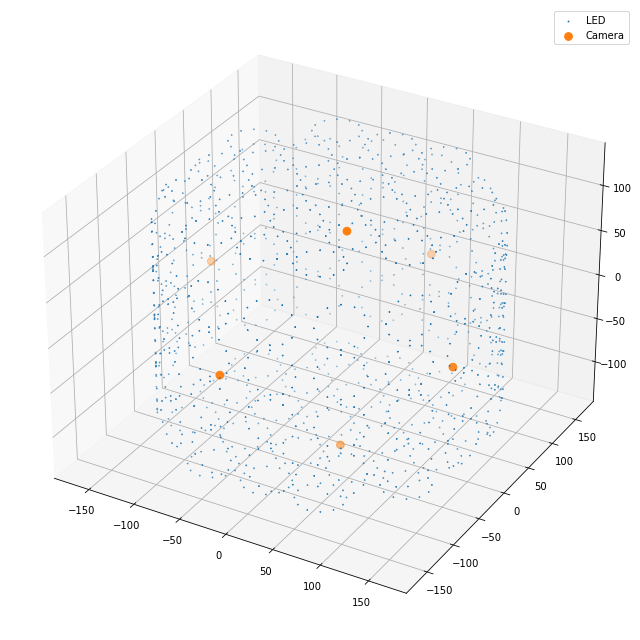

In [49]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
6 images with total of  1223 features
image 0 reprojection errors:    average:15.342952536661766   max: 66.8760788275862
image 1 reprojection errors:    average:17.241562055924263   max: 67.26524606160376
image 2 reprojection errors:    average:16.33529684763169   max: 69.07189540964276
image 3 reprojection errors:    average:16.066497961784666   max: 72.96371831251166
image 4 reprojection errors:    average:15.984364387008986   max: 61.56719760727543
image 5 reprojection errors:    average:15.804475354774615   max: 67.02523038468682
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5752e+05                                    9.65e+05    
       1              2         1.2642e+03      6.56e+05       6.11e+01       2.91e+04    
       2              3         1.1731e+03      9.10e+01       6.62e-01       5.52e+02    
       3              4         1.1710e+

KeyError: '76-7'

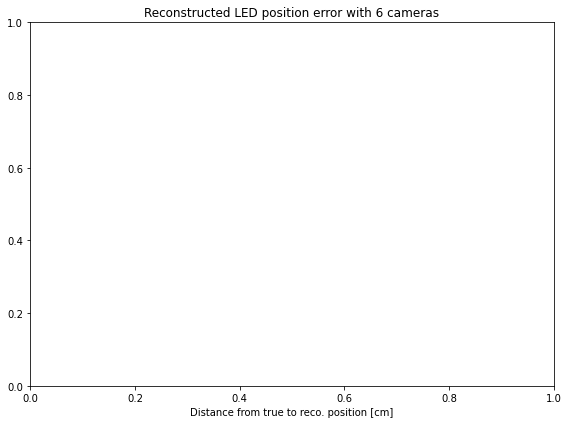

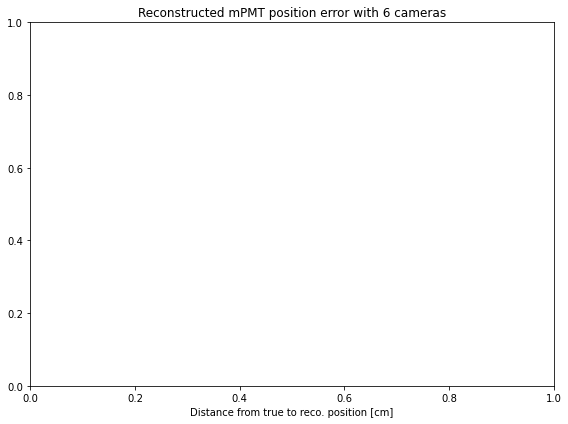

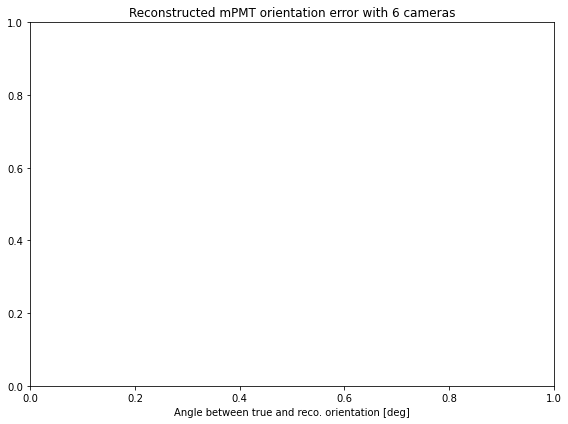

In [50]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

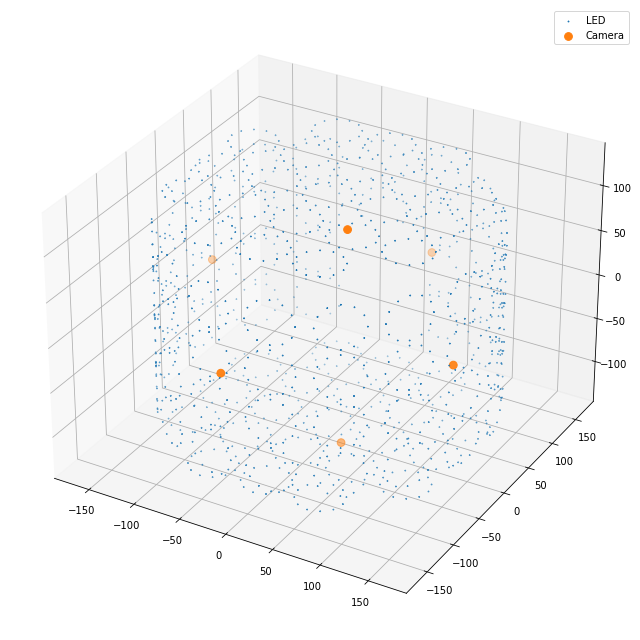

In [51]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

# Simulation with Sony a7R-IV

In [58]:
focal_length = np.array([3526.4, 3622.6])
principle_point = np.array([4719.6, 3240.2])
radial_distortion = np.array([-0.1981, 0.0361])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)
image_size = np.array([9504, 6336])
image_area = [[0,image_size[0]],[0,image_size[1]]]

## 8 camera corner configuration

In [59]:
all_cam_positions = np.array([[97.47275687, 14.93703117, 99.94996814],
                              [29.15674544, 141.7448364, 147.4176074],
                              [44.82084089, 266.7725, -44.9380583],
                              [29.29952975, 16.2275, -28.97664714],
                              [-97.47275687 , 14.93703117, -99.94996814],
                              [99.94996814, 272.2629688, -97.47275687],
                              [99.94996814, 14.93703117, -97.47275687],
                              [-99.94996814, 14.93703117, 97.47275687],
                              [-29.15674544, 141.7448364, -147.4176074],
                              [-147.4176074, 141.7448364, 29.15674544],
                              [-99.94996814, 272.2629688, 97.47275687],
                              [97.47275687, 272.2629688, 99.94996814],
                              [147.4176074, 141.7448364, -29.15674544],
                              [-97.47275687, 272.2629688, -99.94996814]])
corner_cam_positions = all_cam_positions[(0,4,5,6,7,10,11,13),:]
cam_offsets = np.mean(corner_cam_positions, axis=0)
all_cam_positions = all_cam_positions - cam_offsets
corner_cam_positions = corner_cam_positions - cam_offsets

In [60]:
corner_cam_directions = [[-1, +1.9, -1],
                         [+1, +1.9, +1],
                         [-1, -1.9, +1],
                         [-1, +1.9, +1],
                         [+1, +1.9, -1],
                         [+1, -1.9, -1],
                         [-1, -1.9, -1],
                         [+1, -1.9, +1]]

In [61]:
camera_positions = corner_cam_positions
camera_directions = corner_cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({4: 504, 8: 344, 7: 212, 6: 152, 5: 60})


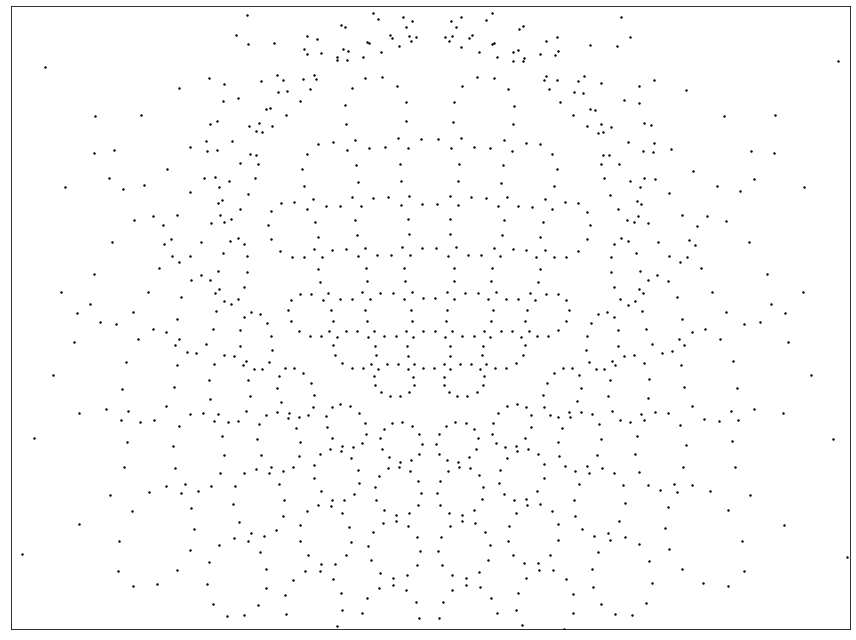

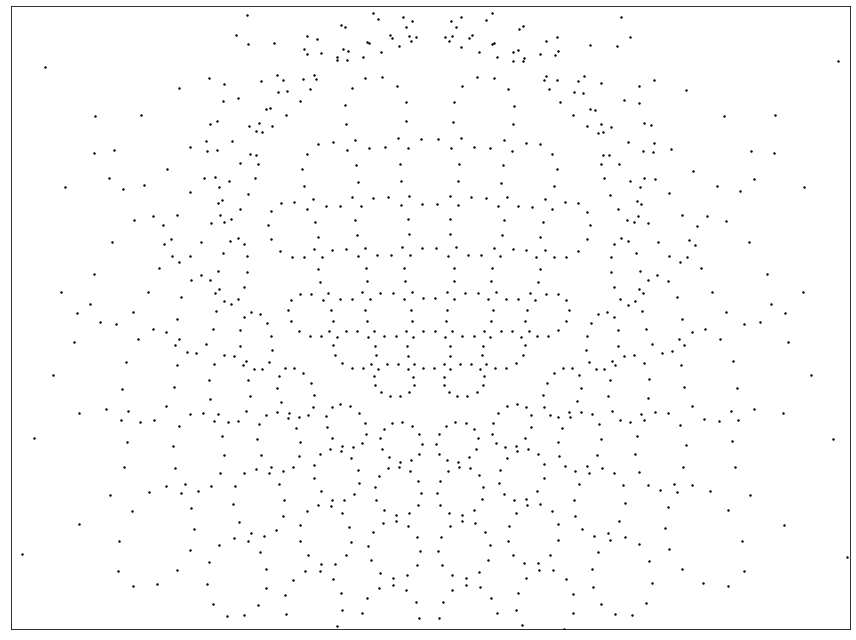

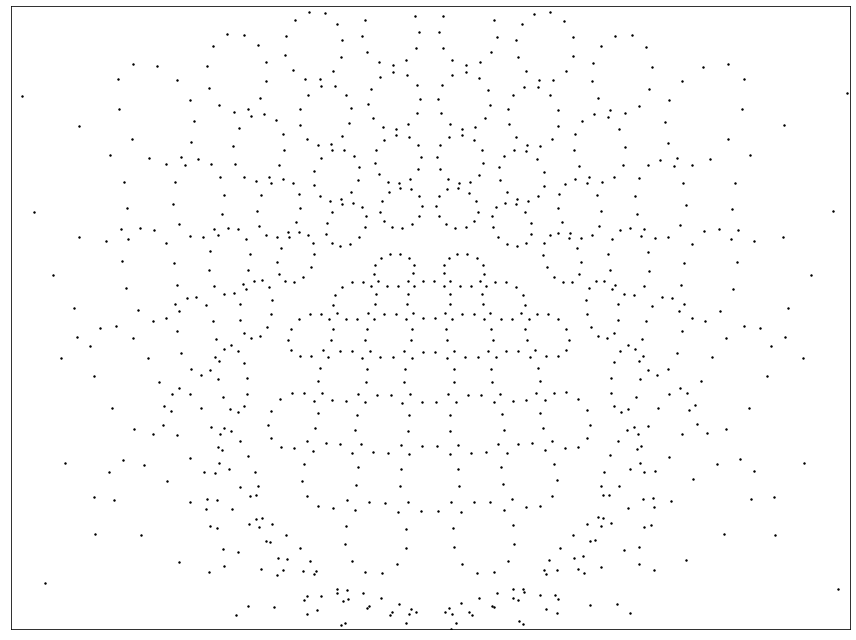

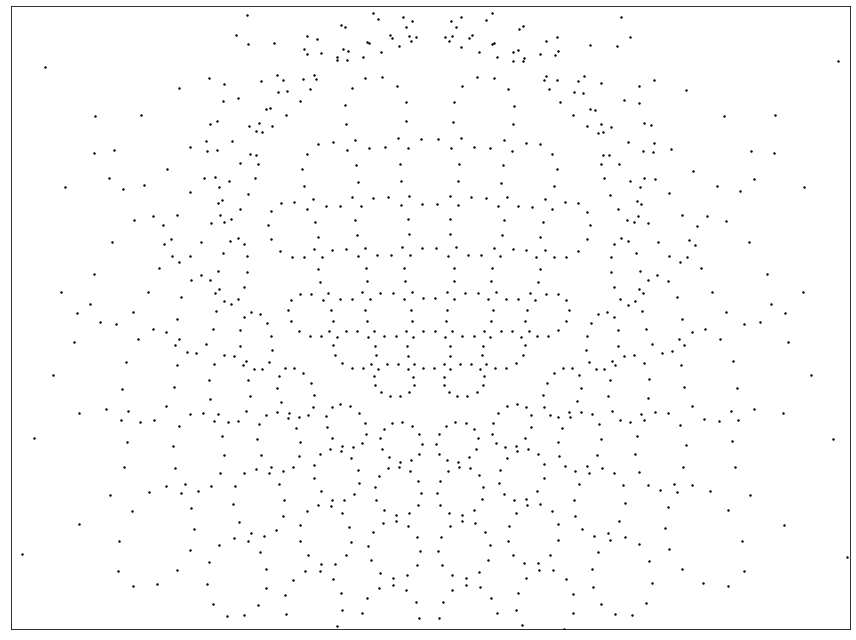

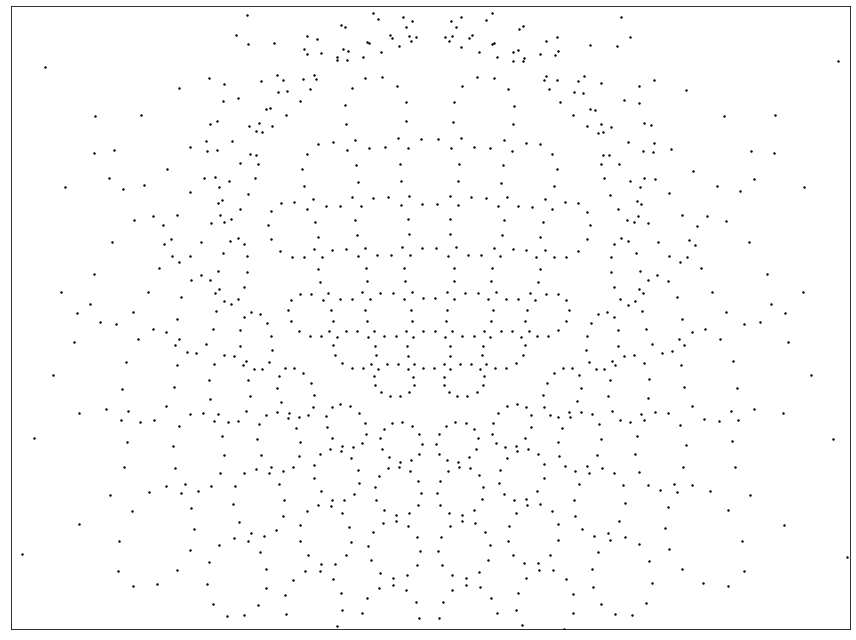

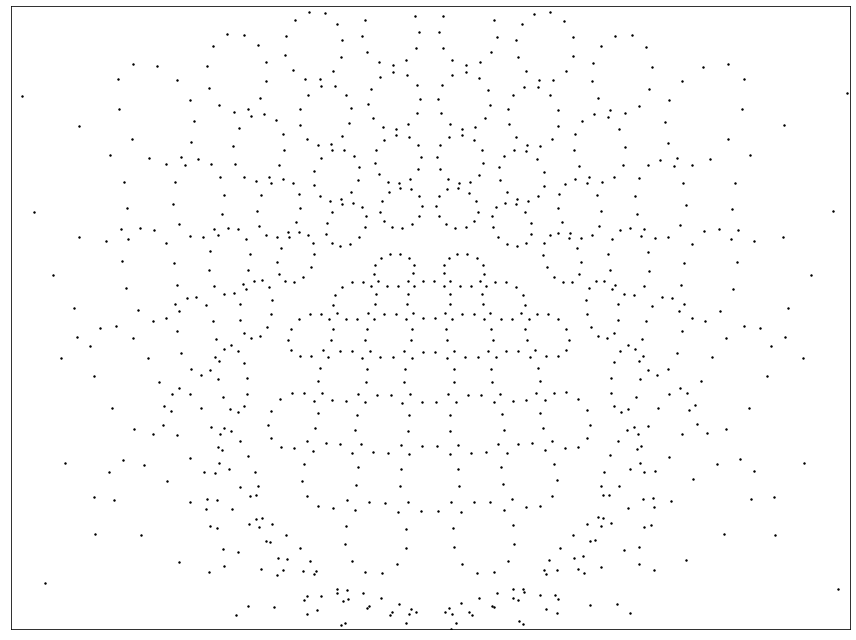

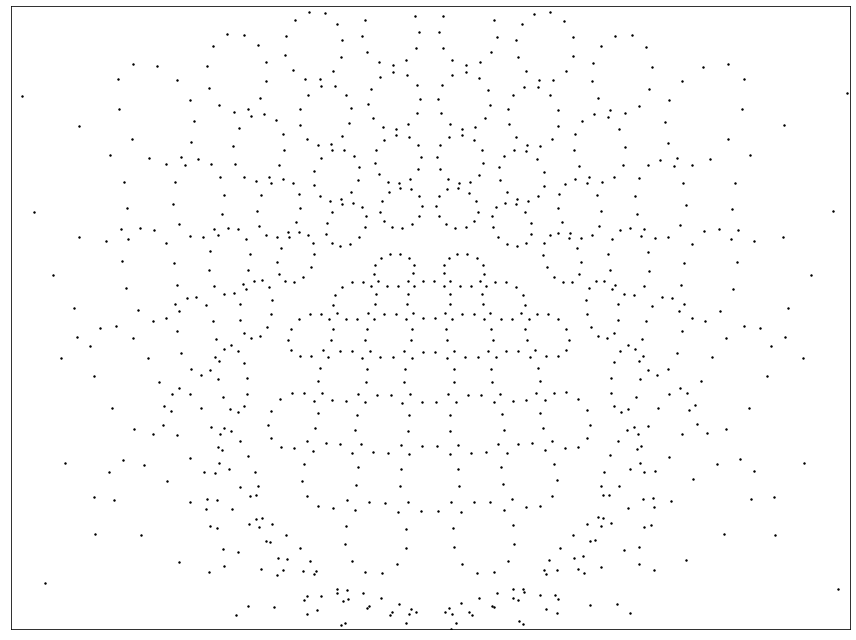

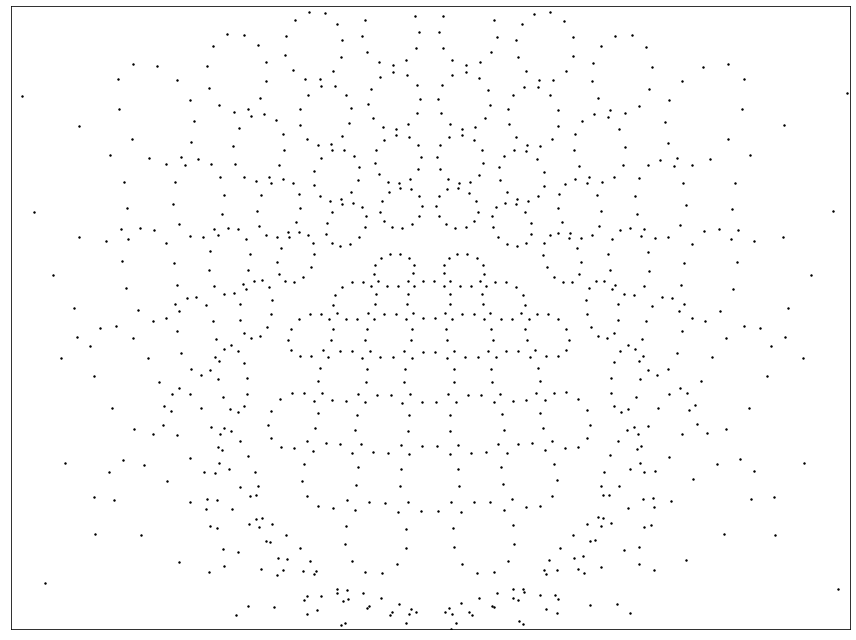

In [62]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

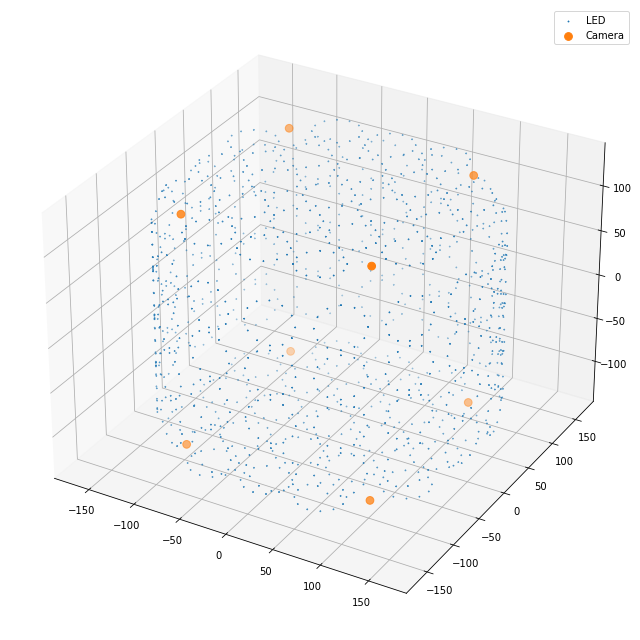

In [63]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:22.264462402833644   max: 377.0328742850373
image 1 reprojection errors:    average:21.694221695581575   max: 248.5391106616894
image 2 reprojection errors:    average:21.46648375029394   max: 214.4193209393158
image 3 reprojection errors:    average:21.728728432513453   max: 713.4642567776021
image 4 reprojection errors:    average:23.010544507316624   max: 555.9822178943259
image 5 reprojection errors:    average:21.76474491025006   max: 175.710935933977
image 6 reprojection errors:    average:22.510237833250088   max: 564.9525615707422
image 7 reprojection errors:    average:21.246286357455897   max: 268.11221735089924
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8700e+06                                    1.18e+07    
       1              2         2.1531e+04      3.85e+

      26             27         8.6620e+04      9.06e-01       5.87e-03       6.20e+01    
`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 3.2625e+06, final cost 8.6620e+04, first-order optimality 6.20e+01.
mean reprojection error: 4.239428688920704
max reprojection error: 14.81183633593874
mean reconstruction error: 0.25011290235774297
max reconstruction error: 1.2736186672016845
=== Gaussian errors on feature image locations: 10.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:23.77868769731182   max: 212.61223246648956
image 1 reprojection errors:    average:23.97877768881696   max: 368.92023156153743
image 2 reprojection errors:    average:23.2373559772466   max: 150.67143172973317
image 3 reprojection errors:    average:24.500777451655722   max: 215.77527520567196
image 4 reprojection errors:    average:24.098302922623464   max: 259.0542432221303
image 5 reprojection errors:    average:24.451869185433324   max: 35

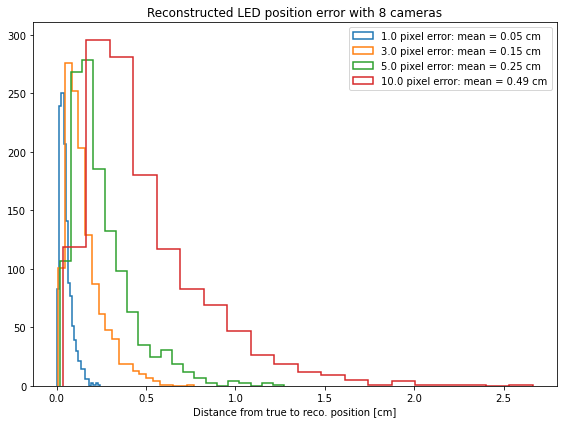

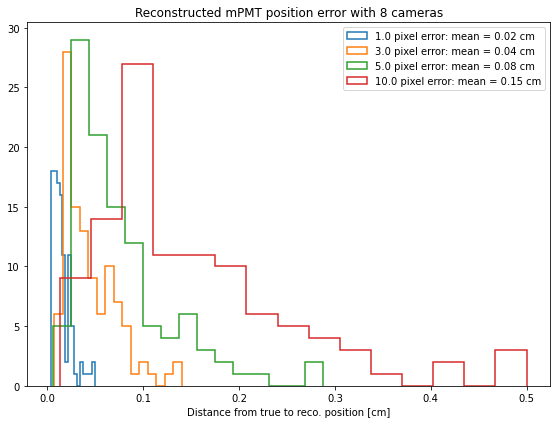

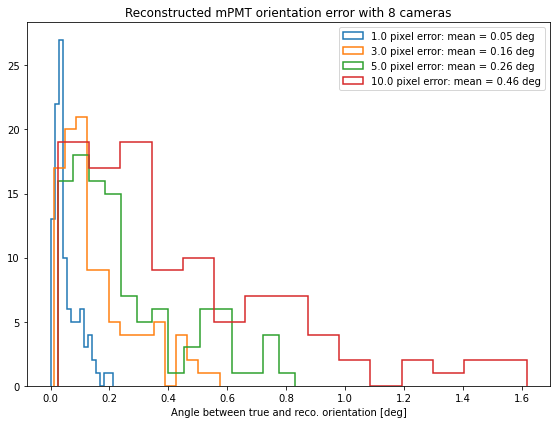

In [64]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

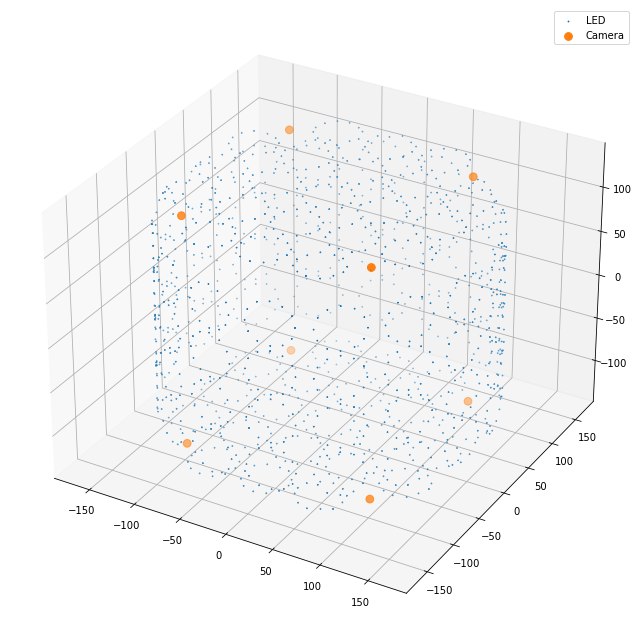

In [65]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 4 camera corner configuration

In [66]:
corner_4cam_positions = all_cam_positions[(0,4,5,10),:]

In [67]:
corner_4cam_directions = [[-1, +1.9, -1],
                         [+1, +1.9, +1],
                         [-1, -1.9, +1],
                         [+1, -1.9, -1],
                         ]

In [68]:
camera_positions = corner_4cam_positions
camera_directions = corner_4cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0])#, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({2: 546, 4: 462, 3: 264})


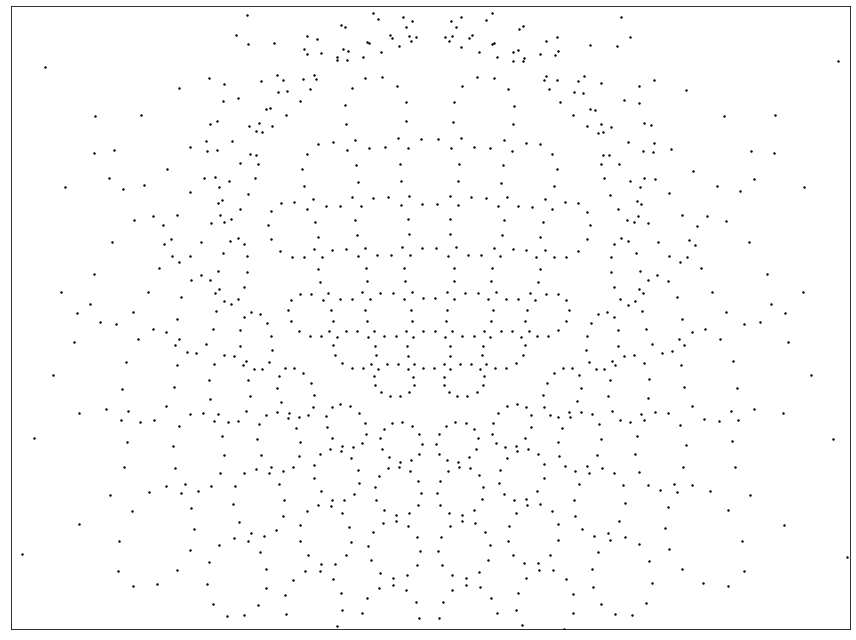

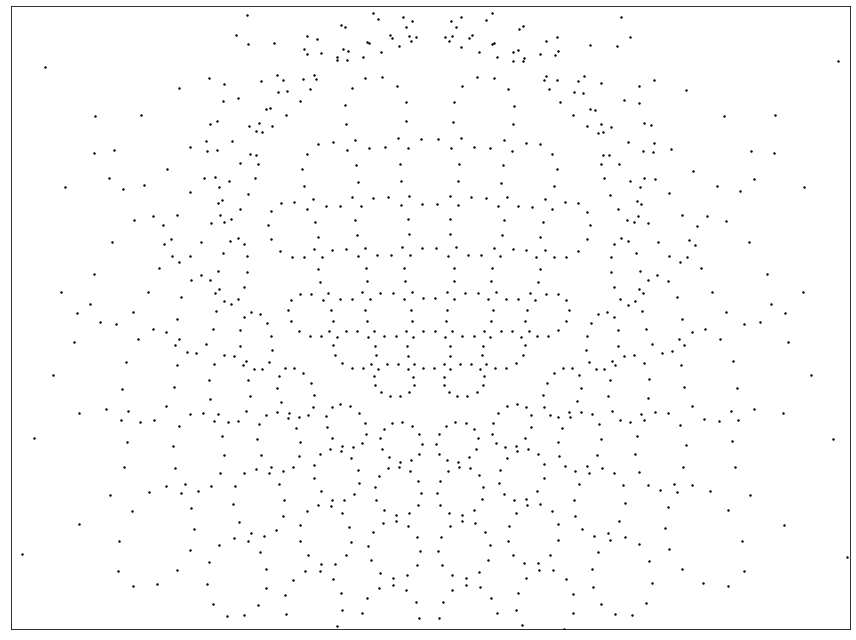

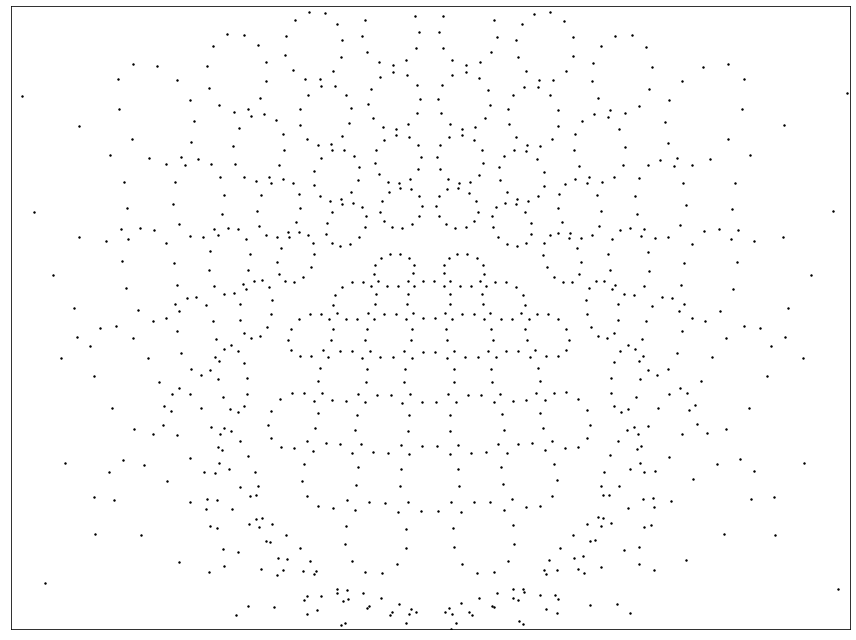

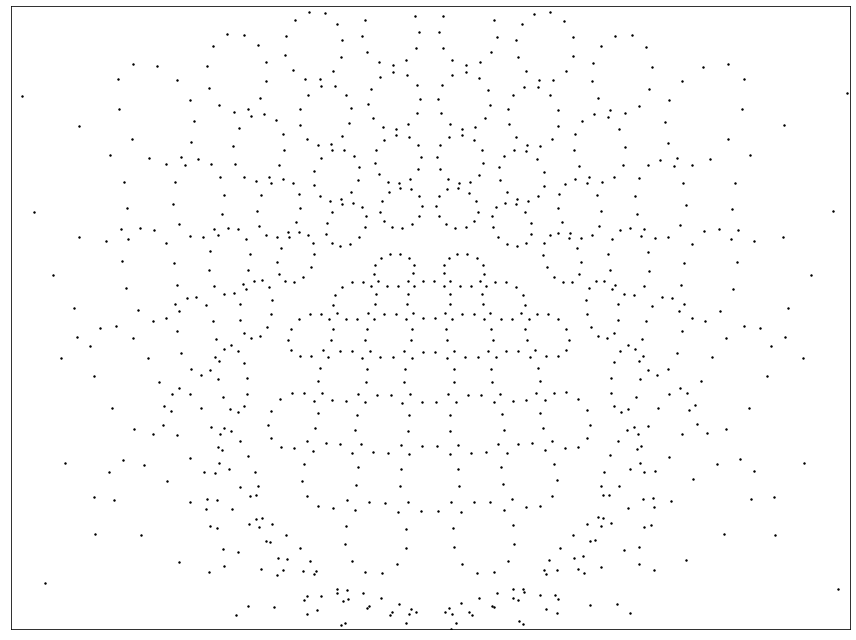

In [69]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

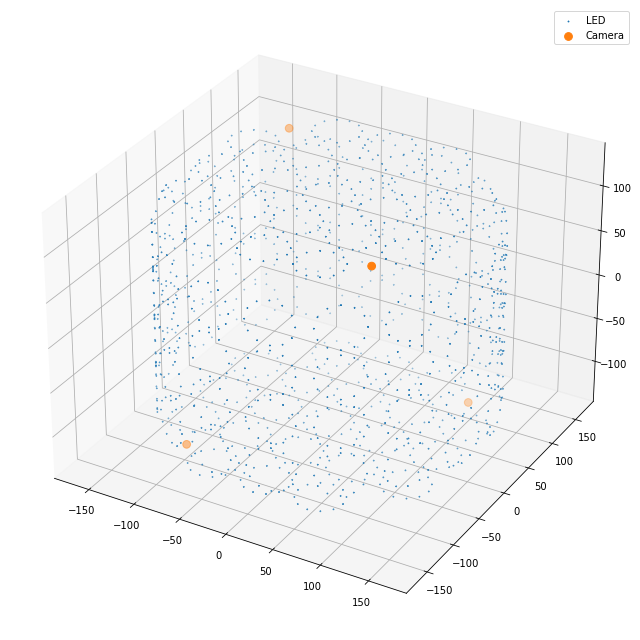

In [70]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
4 images with total of  1272 features
image 0 reprojection errors:    average:22.195833113096693   max: 482.1907827262405
image 1 reprojection errors:    average:21.980512812067968   max: 188.90291200650978
image 2 reprojection errors:    average:21.680381989110735   max: 157.71544954422495
image 3 reprojection errors:    average:21.61669072994175   max: 329.2322411858199
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6145e+06                                    1.08e+07    
       1              2         4.6790e+03      1.61e+06       6.11e+01       6.80e+05    
       2              3         1.1913e+03      3.49e+03       2.11e+00       1.02e+04    
       3              4         1.1883e+03      2.95e+00       1.27e-01       1.10e+03    
       4              5         1.1877e+03      6.74e-01       3.33e-02       1.75e+02    
       5              6

       6              7         1.1209e+05      6.61e+00       5.50e-02       8.13e+02    
       7              8         1.1208e+05      2.69e+00       2.74e-02       3.38e+02    
       8              9         1.1208e+05      2.06e+00       2.47e-02       3.18e+02    
       9             10         1.1208e+05      2.11e+00       2.22e-02       1.91e+02    
      10             11         1.1208e+05      1.70e+00       1.79e-02       2.21e+02    
      11             12         1.1208e+05      1.21e+00       1.22e-02       1.30e+02    
      12             13         1.1207e+05      8.70e-01       9.95e-03       1.62e+02    
      13             14         1.1207e+05      8.13e-01       9.40e-03       1.23e+02    
      14             15         1.1207e+05      1.17e+00       1.46e-02       2.58e+02    
      15             16         1.1207e+05      8.17e-01       7.06e-03       7.62e+01    
      16             17         1.1207e+05      7.67e-01       1.14e-02       2.59e+02    

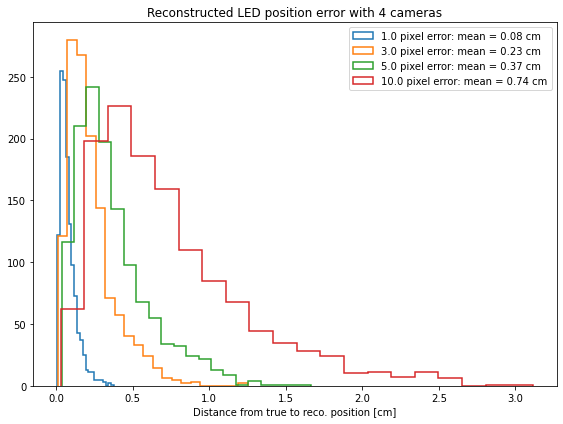

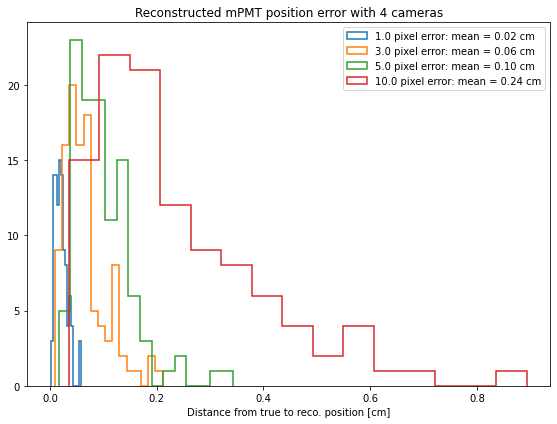

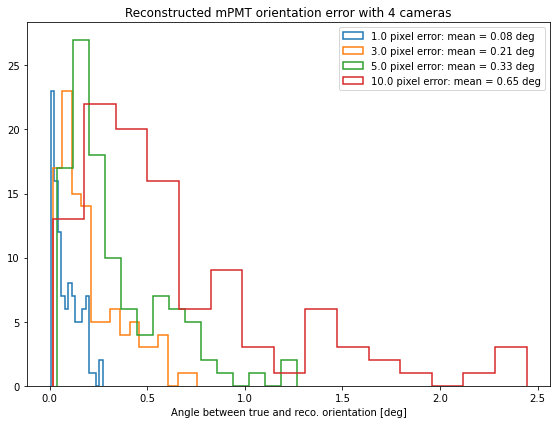

In [71]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

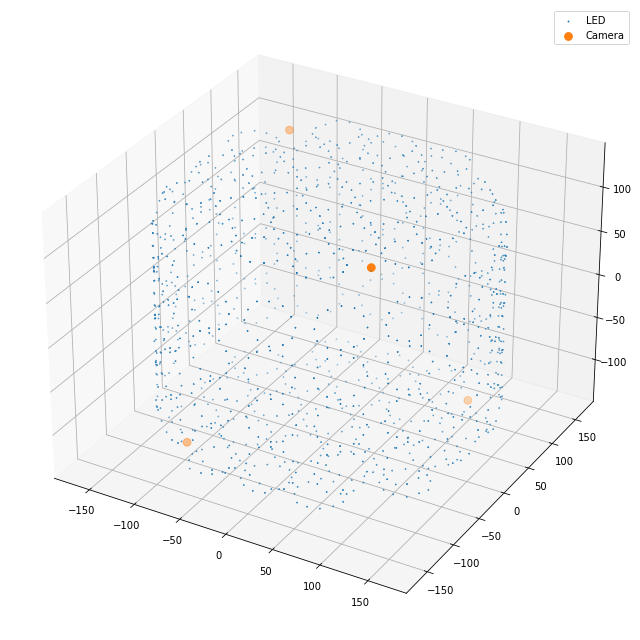

In [72]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 6 camera corner configuration

In [73]:
corner6_cam_positions = all_cam_positions[(4,5,6,7,10,11),:]

In [74]:
corner6_cam_directions = [[+1, +1.9, +1],
                          [-1, -1.9, +1],
                          [-1, +1.9, +1],
                          [+1, +1.9, -1],
                          [+1, -1.9, -1],
                          [-1, -1.9, -1]]

In [75]:
camera_positions = corner6_cam_positions
camera_directions = corner6_cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({3: 519, 6: 397, 5: 235, 4: 121})


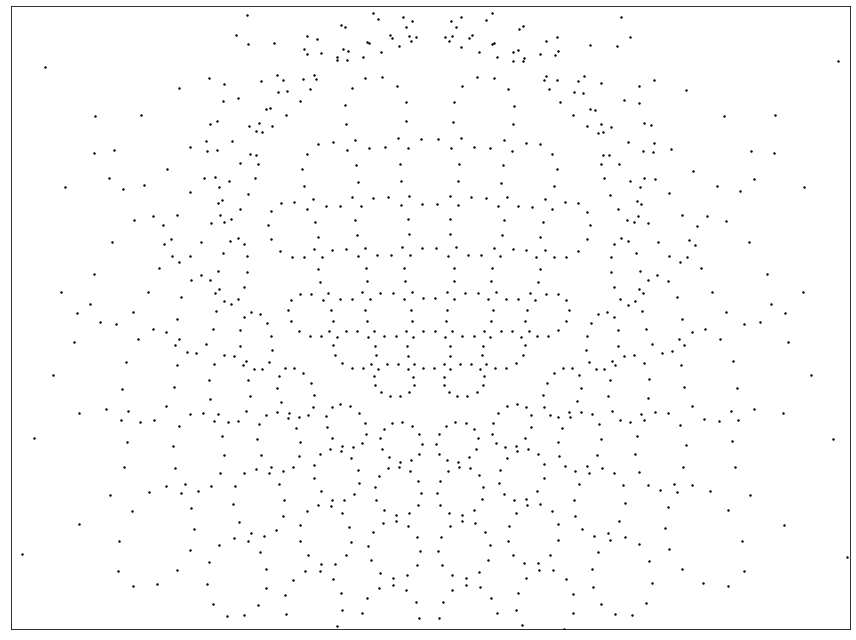

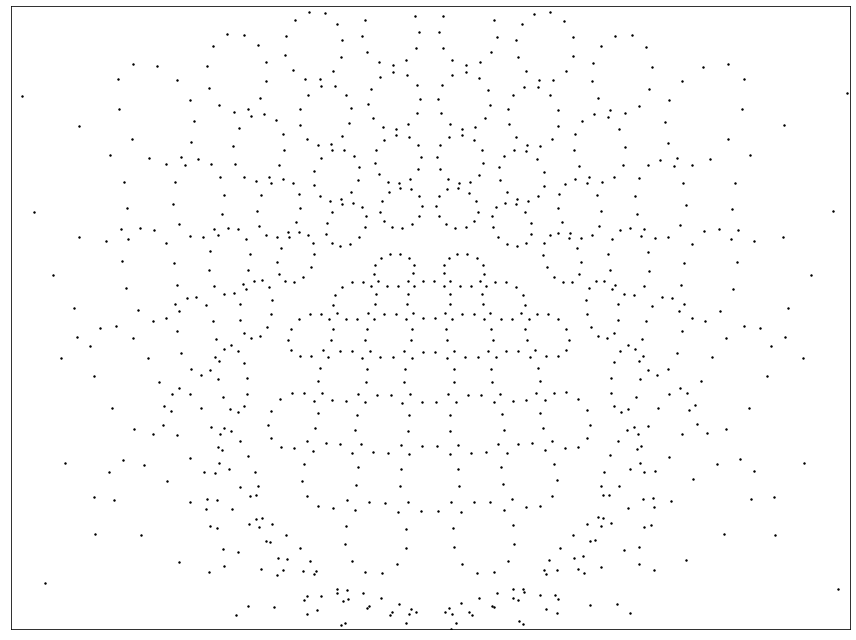

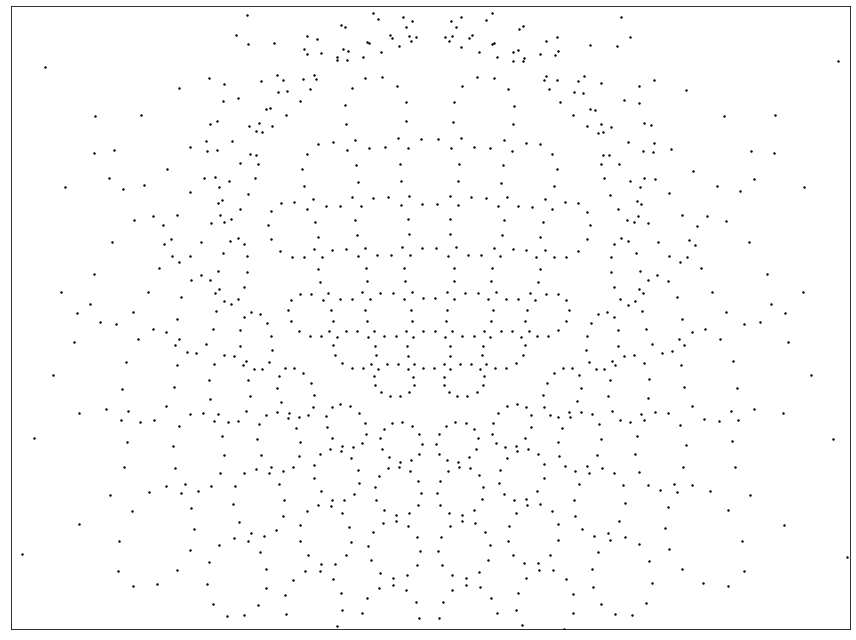

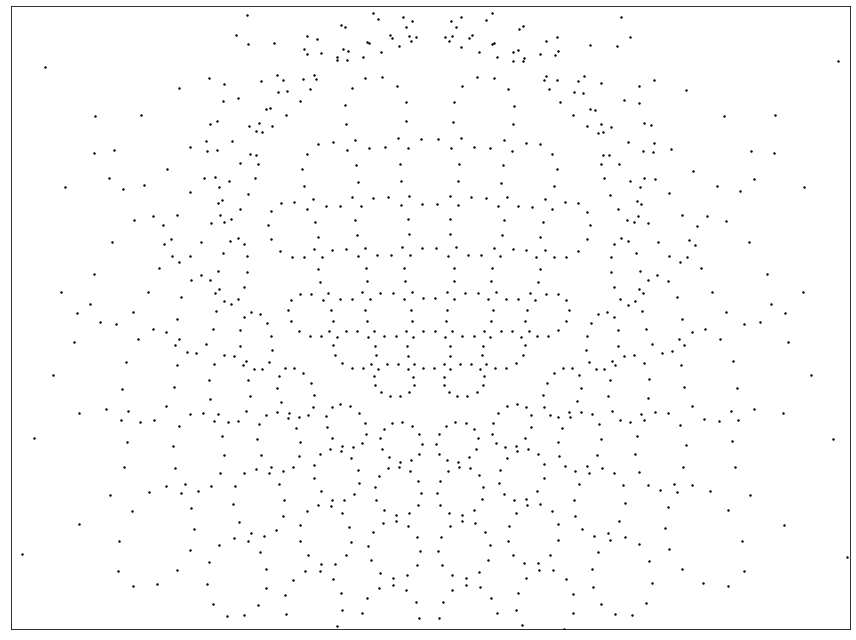

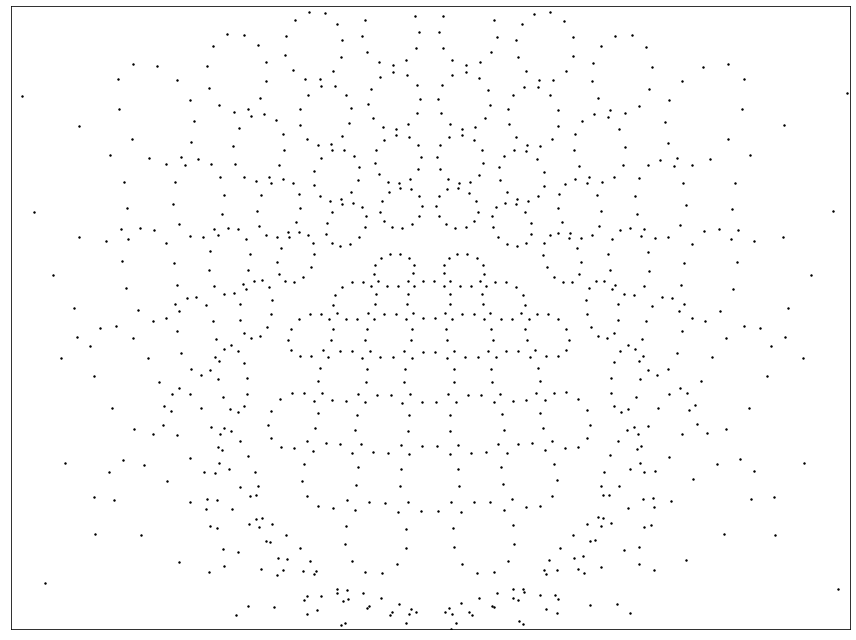

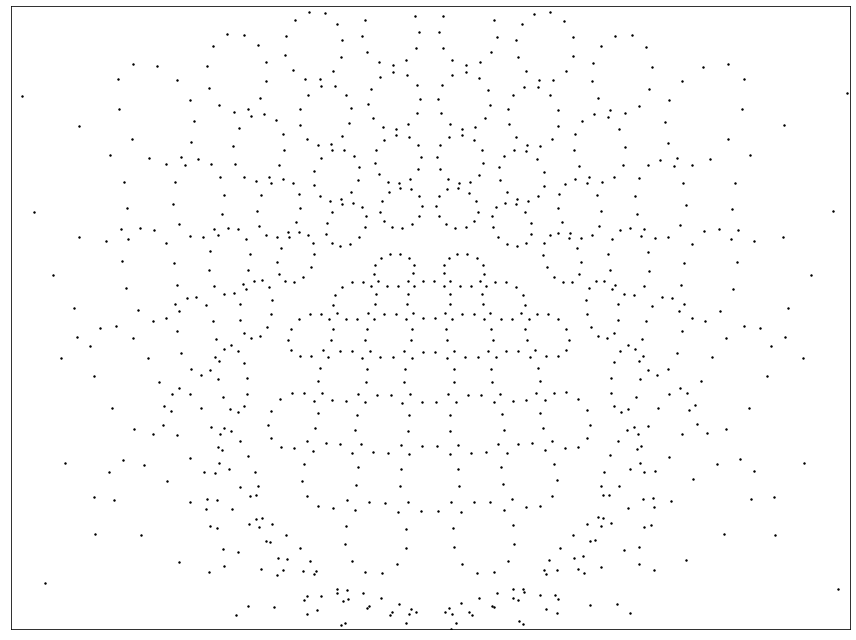

In [76]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

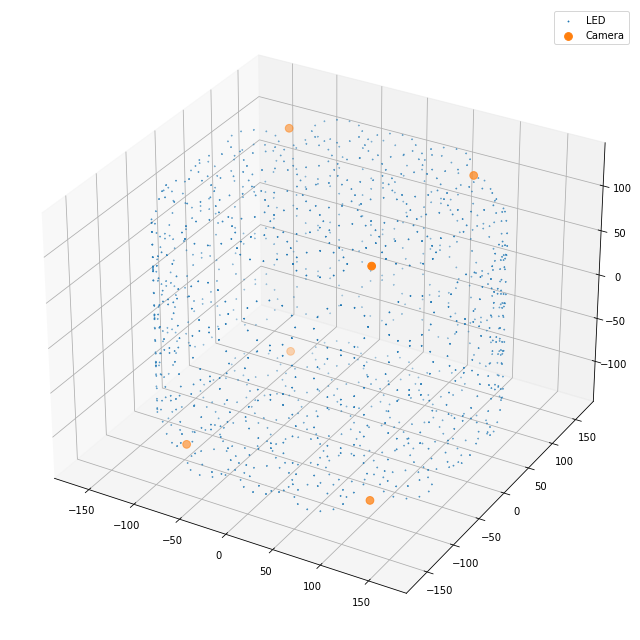

In [77]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
6 images with total of  1272 features
image 0 reprojection errors:    average:21.521537117432654   max: 228.75899826216641
image 1 reprojection errors:    average:22.094526537115975   max: 207.5519265500523
image 2 reprojection errors:    average:21.04955820055219   max: 194.2499535622554
image 3 reprojection errors:    average:21.704116103157226   max: 401.9243028649641
image 4 reprojection errors:    average:21.712405338524015   max: 269.3266754377959
image 5 reprojection errors:    average:21.507903823649407   max: 236.6415247235926
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3892e+06                                    3.60e+06    
       1              2         6.0334e+03      2.38e+06       6.11e+01       3.52e+05    
       2              3         2.3980e+03      3.64e+03       8.85e-01       3.60e+03    
       3              4         2.3872

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2164e+06                                    1.62e+07    
       1              2         2.5067e+05      2.97e+06       6.62e+01       1.65e+06    
       2              3         2.2939e+05      2.13e+04       1.63e+00       5.17e+04    
       3              4         2.2886e+05      5.29e+02       2.59e+00       2.79e+04    
       4              5         2.2871e+05      1.44e+02       3.38e-01       1.12e+03    
       5              6         2.2869e+05      2.06e+01       1.48e-01       8.51e+02    
       6              7         2.2868e+05      9.83e+00       3.52e-02       1.58e+02    
       7              8         2.2868e+05      3.14e+00       2.20e-02       2.13e+02    
       8              9         2.2868e+05      2.23e+00       1.34e-02       1.15e+02    
       9             10         2.2868e+05      2.11e+00       1.76e-02       2.57e+02    

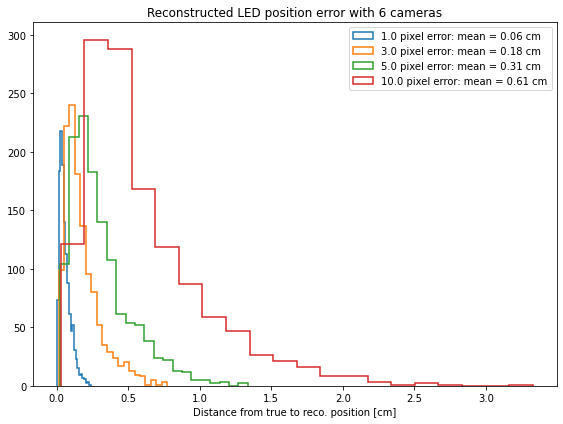

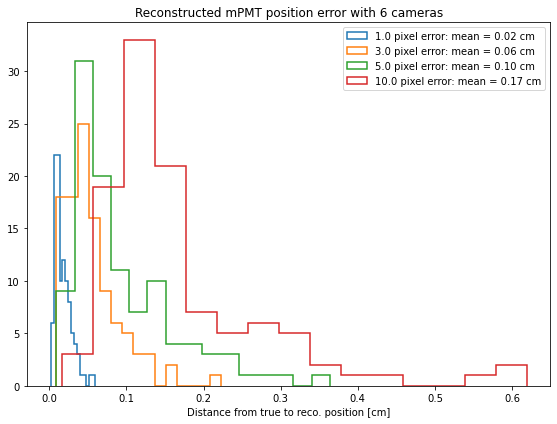

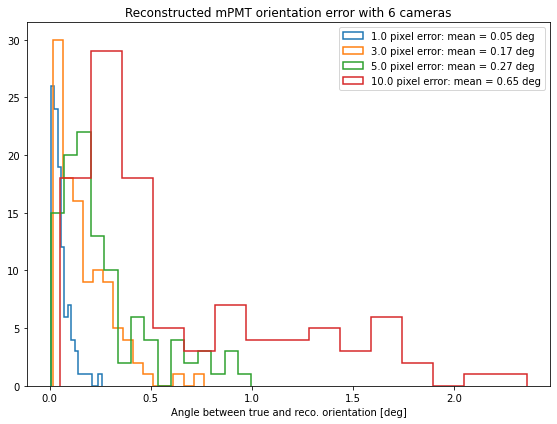

In [78]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

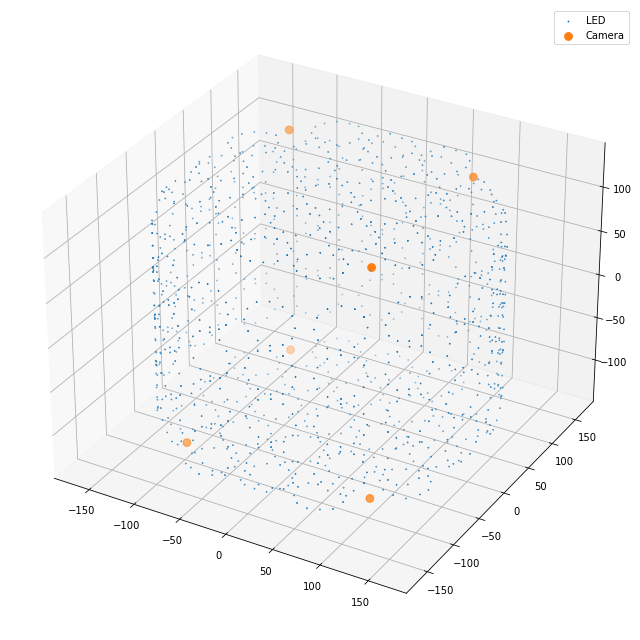

In [79]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 6 camera configuration A

In [80]:
wall_cam_positions = all_cam_positions[(1,2,3,8,9,12),:]

In [81]:
wall_cam_positions

array([[  29.15674544,   -1.85516359,  147.4176074 ],
       [  44.82084089,  123.17250001,  -44.9380583 ],
       [  29.29952975, -127.37249999,  -28.97664714],
       [ -29.15674544,   -1.85516359, -147.4176074 ],
       [-147.4176074 ,   -1.85516359,   29.15674544],
       [ 147.4176074 ,   -1.85516359,  -29.15674544]])

In [82]:
wall_cam_direcions = [[ 0,  0, -1],
                      [ 0, -1,  0],
                      [ 0, +1,  0],
                      [ 0,  0, +1],
                      [+1,  0,  0],
                      [-1,  0,  0]]

In [83]:
# camera_radial_position = 163.0
# camera_halfz_position = 168.0
# camera_positions = np.array([
#     [0, -camera_halfz_position, 0],
#     [0, camera_halfz_position, 0],
#     [camera_radial_position, 0, 0],
#     [-camera_radial_position, 0, 0],
#     [0, 0, camera_radial_position],
#     [0, 0, -camera_radial_position]])
# camera_directions = [[0, 1, 0],
#                      [0, -1, 0],
#                      [-1, 0, 0],
#                      [1, 0, 0],
#                      [0, 0, -1],
#                      [0, 0, 1]]
camera_positions = wall_cam_positions
camera_directions = wall_cam_direcions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([np.pi/2, 0, np.pi/2, 0, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({3: 679, 4: 431, 5: 123, 2: 39})


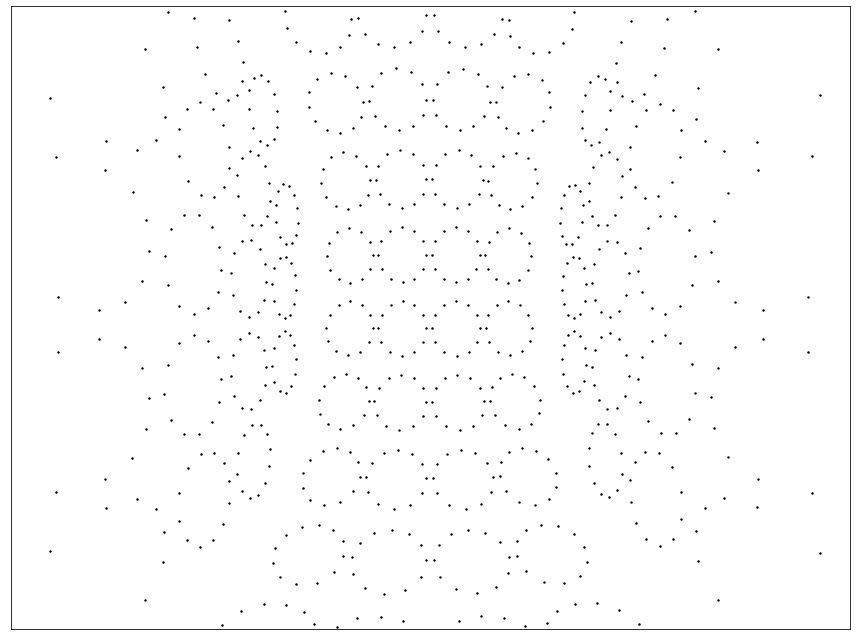

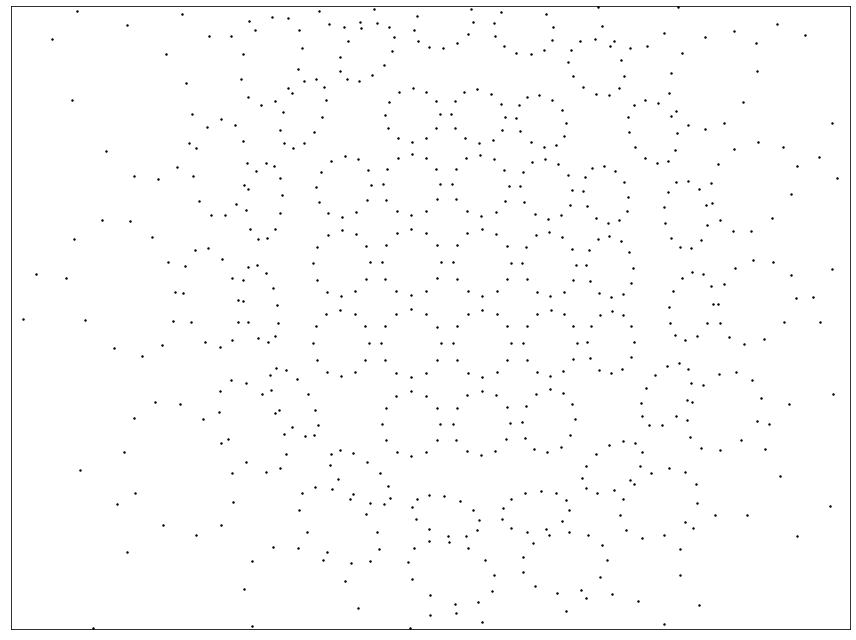

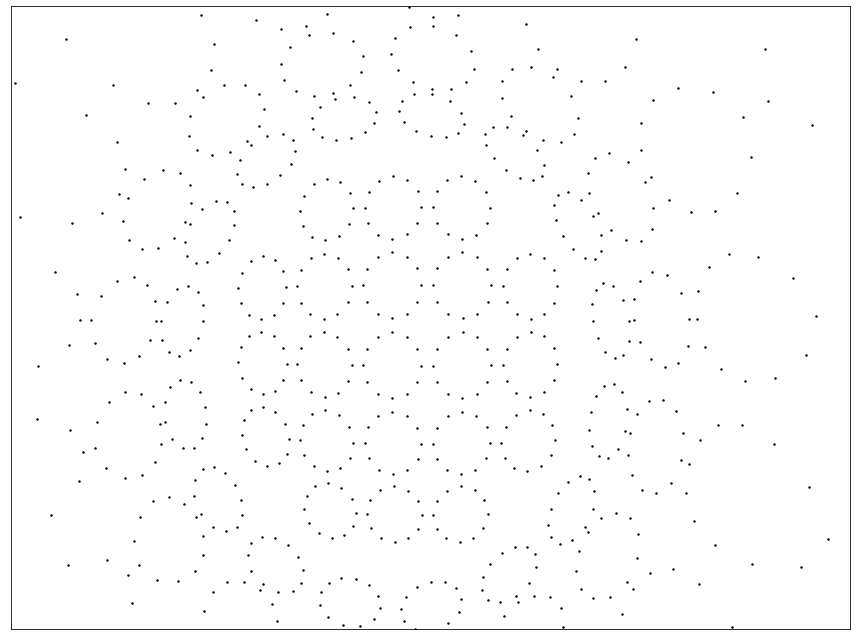

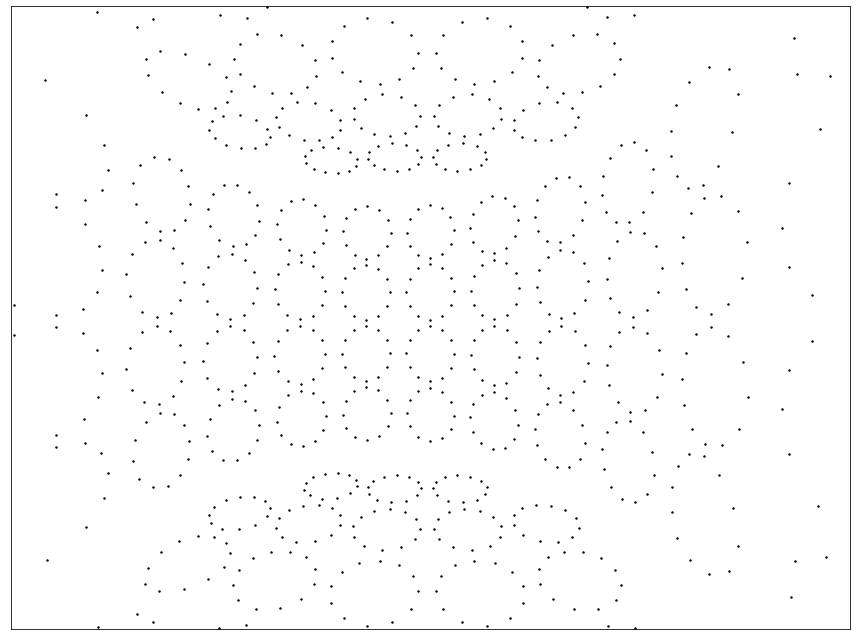

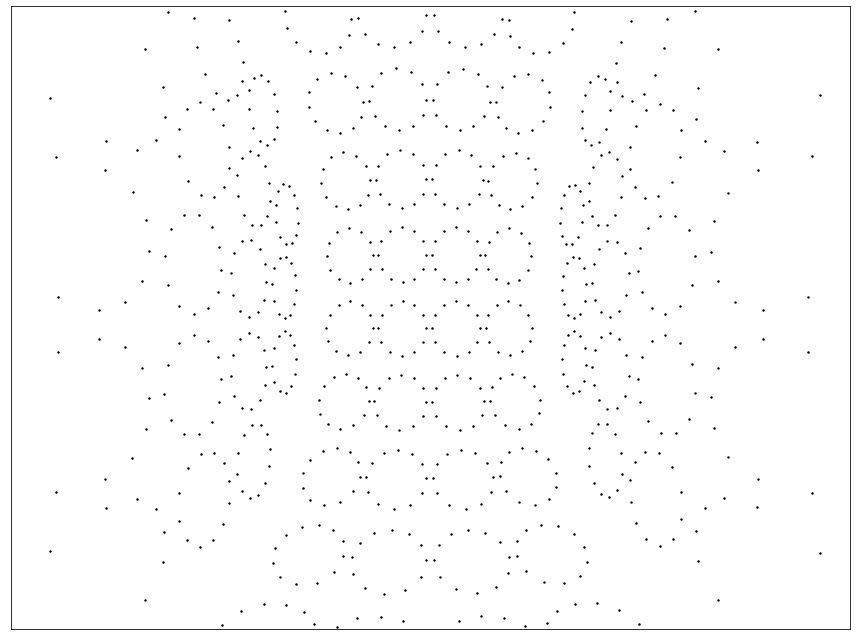

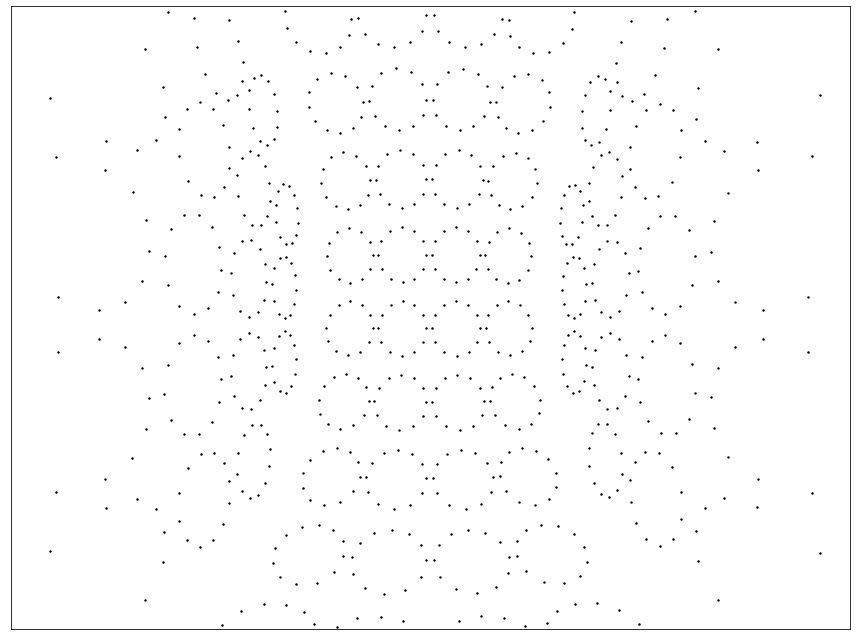

In [84]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

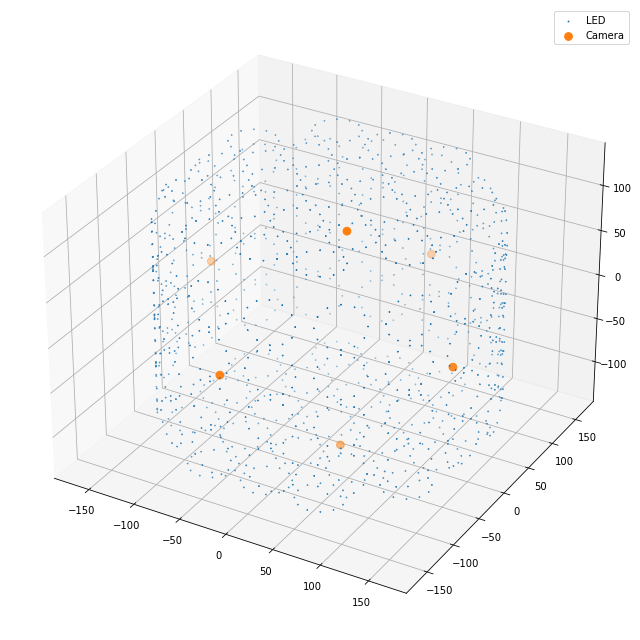

In [85]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
6 images with total of  1272 features
image 0 reprojection errors:    average:20.858704238950686   max: 164.51857526493566
image 1 reprojection errors:    average:23.08158645127888   max: 218.2245004661737
image 2 reprojection errors:    average:22.853147989360476   max: 101.36027530142324
image 3 reprojection errors:    average:22.394074617717934   max: 236.518025867157
image 4 reprojection errors:    average:22.058503659399516   max: 147.68489513962896
image 5 reprojection errors:    average:21.558179984640816   max: 191.75728957345015
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7060e+06                                    4.26e+06    
       1              2         3.1045e+03      1.70e+06       6.14e+01       3.00e+05    
       2              3         1.6239e+03      1.48e+03       1.78e+00       3.12e+03    
       3              4         1.61

      21             22         1.6177e+05      2.94e+00       2.99e-02       2.99e+02    
      22             23         1.6176e+05      2.88e+00       1.94e-02       1.29e+02    
      23             24         1.6176e+05      2.71e+00       2.75e-02       3.42e+02    
      24             25         1.6176e+05      2.93e+00       2.00e-02       1.58e+02    
      25             26         1.6176e+05      1.88e+00       1.65e-02       2.93e+02    
      26             27         1.6175e+05      1.64e+00       1.17e-02       1.61e+02    
      27             28         1.6175e+05      1.24e+00       1.02e-02       2.42e+02    
      28             29         1.6175e+05      1.22e+00       9.93e-03       1.67e+02    
      29             30         1.6175e+05      1.22e+00       1.02e-02       2.71e+02    
      30             31         1.6175e+05      1.22e+00       9.90e-03       1.75e+02    
      31             32         1.6175e+05      1.21e+00       1.01e-02       3.02e+02    

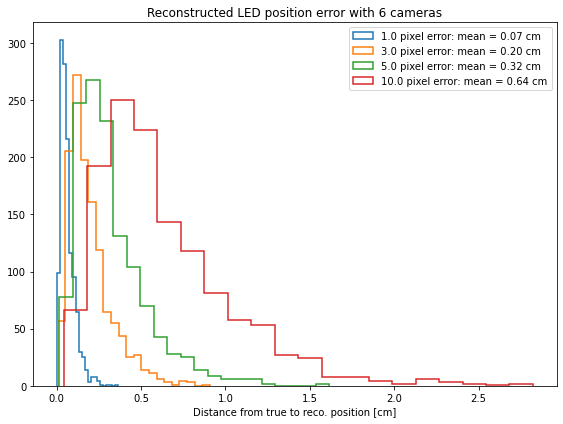

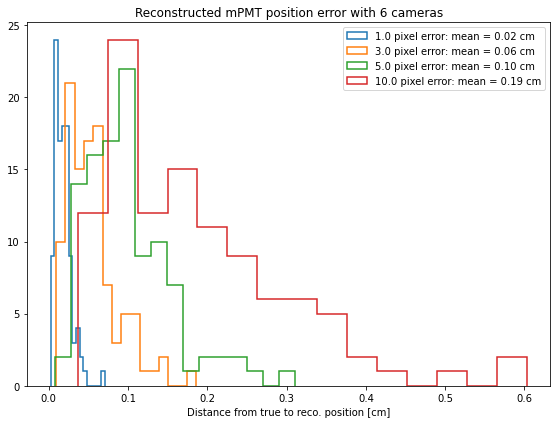

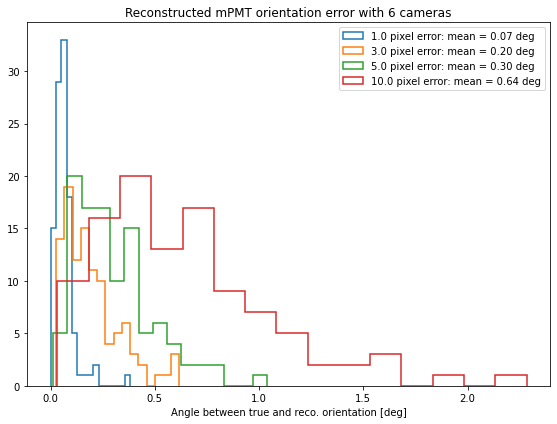

In [86]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

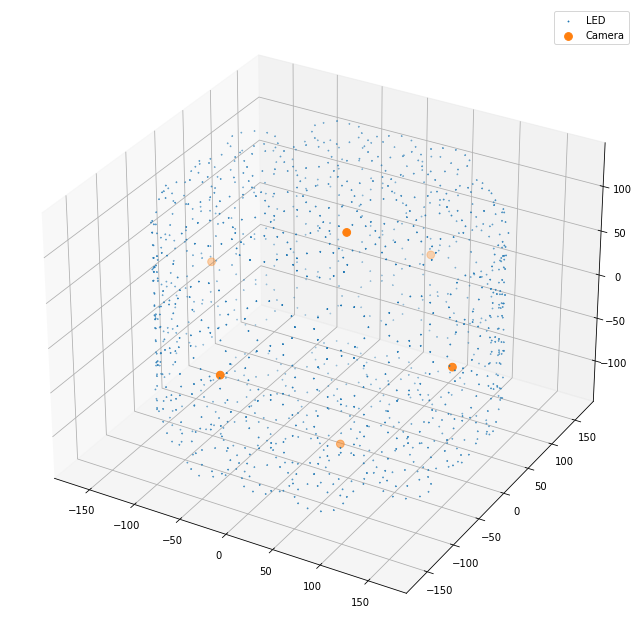

In [87]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)